# <font color="#800080">Segmenting TravelTide Customers with Fuzzy Segmentation:</font>

## <font color=#DA70D6> Introduction:</font>
This is an __Exploratory Data Analysis__ for __TravelTide__, a _fictional_ e-booking startup. Our primary objective is __customer segmentation__ with the end goal of determining suitable perks to enhance customer retention. This notebook presents the initial phase of our analysis using Python, encompassing data understanding, cleaning, and preparation for subsequent analytical steps. 
The following data is the outcome of a SQL query that joined four tables:
* __Table 1. Users:__ user demographic information
* __Table 2. Sessions:__ information about individual browsing sessions
* __Table 3. Flights:__ information about purchased flights
* __Table 4. Hotels:__ information about purchased hotel stays

__Cohort:__ Based on Marketing Manager's request we included sessions starting _after_ the New Years holiday __(2023-01-04)__ until the last available date in the database __(2023-07-23)__, and only include the users with __more than 7 sessions__ during the same time period. This lets us analyze customer behaviour within a fixed time frame.

Following up on our meeting with the Marketing Manager of the company, these are the perks most likely to attract customers: 

* __Free hotel meal__
* __Free checked bag__
* __No cancellation fees__
* __Exclusive discounts__
* __1-night free hotel with a flight__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for scaling the data
from sklearn.preprocessing import StandardScaler 

# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set the ggplot style 
plt.style.use('ggplot')

# Load the dataset
cohort_users = pd.read_csv('TravelTide Cohort SQL.csv')

## <font color=#DA70D6>Data Understanding and handling Null values</font>
### Let's get some general info about our data:

In [2]:
cohort_users.shape

(5998, 31)

In [3]:
# check for missing values
cohort_users.isna().sum()

user_id                                      0
sign_up_date                                 0
age                                          0
gender                                       0
married                                      0
has_children                                 0
home_country                                 0
home_city                                    0
session_count                                0
avg_session_duration_minute                  0
avg_page_clicks                              0
total_trips                                  0
conversion_rate                              0
weekend_trip_proportion                      0
cancellation_proportion                    432
avg_booking_departure_gap_days_flights     792
avg_booking_departure_gap_days_hotels      563
total_flights_booked                         0
round_trips_proportion                       0
avg_flight_price_usd                       792
avg_flight_discount_amount                1277
discounted_fl

I can see an interesting pattern in the number of null values, we have the same number of null values related to flights (`booking_departure_gap_days_flights`, `avg_flight_price_usd`, `avg_flight_seats`, `avg_checked_bags`, `avg_distance_flown_km)`, and the same number of null values related to hotels (`booking_departure_gap_days_hotels`, `avg_hotel_price_usd`, `avg_hotel_rooms`, `avg_stay_duration_day`). That's good! Because not all the users booked both flights and hotels together.

Also, we got some null values for `cancellation_proportion`, `avg_flight_discount_amount` and `avg_hotel_discount_amount` that also make sense, not all users got discounts for their bookings.

Given that we're planning to implement **Fuzzy Segmentation** and we want to create some new metrics using the existed features, the approach to handle null values and data transformation becomes very crucial.

## <font color=#DA70D6> Handling Null Values:</font>

Let's check out one by one the meaning of null values in each column and based on that decide how to deal with it:
 
### <font color=#52009D>1. cancellation_proportion:</font>

**Meaning of NULL:** The user hasn't booked any trip.

**Meaning of 0:** The user has booked at least one trip and has not cancelled any.

I will use this feature later in calculating the **last_min_booker_index** alongside `avg_booking_departure_gap_days`. We want to use the index at the end for offering the **No cancellation fee** perk, so Higher `cancellation_proportion` and Lower `avg_booking_departure_gap_days` are in our favour. 

My approach for calculating the **last_min_booker_index** will be the **weighted sum**, so I want to ensure that null values in the cancellation_proportion don't distort or unfairly impact the index.

Considering that a null in cancellation_proportion means the user hasn't booked any trip, and a value of 0 means the user booked but didn't cancel any trip, here's my approach:

**Approach for Null Handling:**

**Fill with a Neutral Value:** If the user hasn't booked any trip (i.e., null in cancellation_proportion), we can consider it neutral from a cancellation perspective. It's neither good nor bad from a propensity to cancel viewpoint since they never engaged in the act of booking to begin with. With this, both users who haven't booked and those who booked but didn't cancel will have the same value (**0**) in `cancellation_proportion`. The distinction is subtle, but from the perspective of cancellation propensity, they are functionally similar.

**Flagging:**

Even after filling null values with 0, we might still want to differentiate between users who never booked and those who booked but didn't cancel. To capture this I will also create a binary column (`has_booked`) that is *True* for users who have booked (whether they cancelled or not) and *False* for users who never booked. Later if we ever need to differentiate or analyze these user groups separately, we can use the has_booked flag.

In [4]:
# flagging users based on flight bookings:True if the user has booked a flight and False if hasn't 
cohort_users['has_booked'] = ~cohort_users['cancellation_proportion'].isna()

# filling cancellation_proportion column null values with 0
cohort_users['cancellation_proportion'].fillna(0, inplace=True)

### <font color=#52009D>2. avg_booking_departure_gap_days_flights</font> and <font color=#52009D> avg_booking_departure_gap_days_hotels:</font>

The booking to departure gap time in days metrics are the result of the difference between the end of the user's browsing session and flight departure time / hotel check-in time. I added the hotel check-in time as not all the members have booked both hotel and flights together. If you check you'll see, in the case of having both metrics, the flight one is bigger than the hotel one. So before deciding what to do with their null values, I'll combine these two columns by keeping the bigger amount.

In [5]:
# Determine the position to insert the new column after the last_min_booking columns
position = cohort_users.columns.get_loc('avg_booking_departure_gap_days_hotels') + 1

# Insert the new column which is the maximum of the both columns at the desired position
cohort_users.insert(position, 'avg_booking_departure_gap_days', 
            cohort_users[['avg_booking_departure_gap_days_flights', 'avg_booking_departure_gap_days_hotels']].max(axis=1))

# Drop the original columns
cohort_users.drop(columns=['avg_booking_departure_gap_days_flights', 'avg_booking_departure_gap_days_hotels'], inplace=True)

In [6]:
# check the number of null values of the new column 'avg_booking_departure_gap_days'
null_values = cohort_users['avg_booking_departure_gap_days'].isna().sum()
print(f'We have {null_values} null values in avg_booking_departure_gap_days column.')

We have 432 null values in avg_booking_departure_gap_days column.


**Considerations for handling null values:**

**Meaning of Null:** User hasn't booked either a flight or hotel.

**Nature of Data:** This column represents a time duration between booking time and departure time. The more significant this value, the earlier a user books. A smaller value indicates last-minute bookings.

As I already have mentioned I will use this column in calculating **last_min_booker_index** alongside `cancellation_proportion`. In the formula, we will subtract this value from the maximum gap in the dataset. It means that smaller values (indicative of last-minute bookings) will yield a higher contribution to the index.

For users who haven't booked, their tendency to be last-minute bookers is technically unknown. They neither booked early nor late. We need a strategy that neither penalizes nor rewards these users disproportionately in the final index.

**Approach for Null Handling:**

**Max Value Imputation:** Given our formula for the index, users with the highest `avg_booking_departure_gap_days` (i.e., those who book well in advance) would contribute the least to the index. To ensure users who haven't booked don't get undue advantages or disadvantages in the index, one can impute their gaps with this maximum value.By using the maximum value, users who haven't booked essentially get a neutral score in the last_min_booker_index calculation. They're neither treated as early bookers nor last-minute bookers.

**Flagging:**
We already flagged users based on the cancellation_proportion column (with `has_booked`), that flag also indirectly captures the users who haven't booked a flight or hotel. 

In [7]:
max_gap = cohort_users['avg_booking_departure_gap_days'].max()
cohort_users['avg_booking_departure_gap_days'].fillna(max_gap, inplace=True)

### <font color=#52009D>3. Flight-related columns:</font>
`avg_flight_price_usd`, `avg_flight_discount_amount`, `avg_flight_seats`, `avg_checked_bags`, and `avg_distance_flown_km`

**Meaning of Null:** User hasn't booked a flight / in case of the `avg_flight_discount_amount` user hasn't received a discount in flight bookings.

I will use these columns later to create new metrics. Starting with **average dollar saved per kilometer** I will use the following formula:

**avg_usd_saved_per_km = avg_flight_discount_amount * avg_flight_price_usd / avg_distance_flown_km**


Then I'll use it to calculate another index, `bargain_hunting_index` using the **weighted average** method which will be used for categorising our **price-sensitive customers** to offer **Exclusive Discounts** perk. 
I will use the following formula:

**bargain_hunting_index = w1*conversion_rate + w2* scaled_avg_session_duration_minute + w3*scaled_avg_page_clicks + w4*avg_flight_discount_amount + w5*discounted_flight_proportion + w6*avg_hotel_discount_amount + w7*discounted_hotel_proportion + w8*scaled_avg_usd_saved_per_km**

Where w1-w8 are the weights for each metric.

**Approach for Null Handling:**

The approach should prioritize preserving the meaningfulness of the derived metrics and not introducing unnecessary bias in the final index.

**Flagging:** We flag the users who haven't booked a flight. This will always give us the flexibility to handle them differently in subsequent analyses if necessary.

`avg_flight_discount_amount`: Since it represents the average discount amount the user received on flights, a null value indicates the user never booked a flight and hence never received a discount. Given that we're using it directly in the **bargain_hunting_index** and in the **avg_usd_saved_per_km** metric, it's reasonable to set the null values to **zero**. It implies they saved nothing, which is accurate.

`avg_distance_flown_km`: We're using this column to calculate **avg_usd_saved_per_km**. If it is zero or null, the metric becomes undefined. A zero value for `avg_distance_flown_km` would imply infinite savings (division by zero), which is misleading. Instead, we replace null values in this column with its medians. This will have the effect of assigning users who haven't flown a value of `avg_usd_saved_per_km` that is representative of an average user. This assumes that had they flown, their behavior might have been average.

`avg_flight_price_usd`: Using zero would suggest that a user booked a flight for free, which could be misleading and skew the data analysis. Using the median would imply the user has a typical spending pattern for flights, even though they haven't booked one. This method carries the assumption that if they were to book, their booking price would be close to the median.

`avg_flight_seats` & `avg_checked_bags`: These metrics, represent the average number of seats booked and checked_bag per flight, and are likely indicative of the group size. A higher value implies group or family bookings. We will need to use them later in calculating indexes for **Free hotel meal** and **Free checked bag**.  Fill the null values in both columns with **0** directly represents that they haven't booked any seats or had a checked bag. Given that higher values are more attractive for the mentioned perks, this approach will naturally rank non-flyers lower, which aligns with the logic I mentioned.

In [8]:
# Flag users who haven't booked a flight
cohort_users['has_booked_flight'] = ~cohort_users['avg_flight_price_usd'].isna()

# Columns to fill with 0
zero_fill_columns = ['avg_flight_discount_amount', 'avg_flight_seats', 'avg_checked_bags']

# Columns to fill with their medians
median_fill_columns = ['avg_flight_price_usd', 'avg_distance_flown_km']

# filling null values with zero
for col in zero_fill_columns:
    cohort_users[col].fillna(0, inplace=True)

# filling null values with median
for col in median_fill_columns:
    cohort_users[col].fillna(cohort_users[col].median(), inplace=True)

### <font color=#52009D>3. Hotel-related columns:</font>
`avg_hotel_price_usd`, `avg_hotel_discount_amount`, `avg_hotel_rooms`, and `avg_stay_duration_day`

**Meaning of Null:** User hasn't booked a hotel/ in case of the `avg_hotel_discount_amount` user hasn't received a discount in flight bookings.

I will use these columns later to create new metrics.  I already mentioned the `bargain_hunting_index` where `avg_hotel_discount_amount` will be used alongside other metrics.  

As I also already mentioned we are going to calculate an index to help us to segment the users to offer **Free hotel meal** and **Free checked bags**. `avg_hotel_rooms` and `avg_hotel_price_usd` will be used there alongside other metrics. Higher `avg_hotel_rooms` and lower `avg_hotel_price_usd` will be in our favor. Higher`avg_stay_duration_day` also will support the calculation of the index.

**Approach for Null Handling:**

**Flagging:** Like before we flag the users who haven't booked a hotel. Given the context provided and the usage of the columns, here's how you can handle null values:

`avg_hotel_price_usd`: Using zero would suggest that a user booked a hotel for free, which could be misleading and skew the data analysis. Using the median would imply the user has a typical spending pattern for hotels. This method carries the assumption that if they were to book, their booking price would be close to the median.

`avg_hotel_discount_amount`: Null values mean that the user hasn't booked a hotel and thus hasn't received any discount. This can be filled with 0 as it signifies that the user didn't save anything on hotel bookings. This will support the "bargain_hunting_index" calculation, as users who haven't availed any discounts would be at the lower end of the index.

`avg_hotel_rooms`: If a user hasn't booked a hotel, it means they've booked 0 rooms. Filling null values with 0 makes sense for this column.

`avg_stay_duration_day`: A user that hasn't booked a hotel hasn't stayed any number of days. It's logical to fill the null values with 0 in this context. This is particularly important as we're associating longer stays with **free checked bags** perk.

In [9]:
# Flag users who haven't booked a hotel
cohort_users['has_booked_hotel'] = ~cohort_users['avg_hotel_price_usd'].isna()

# Columns to fill with 0
zero_fill_columns = ['avg_hotel_discount_amount', 'avg_hotel_rooms', 'avg_stay_duration_day']

# Columns to fill with their medians
median_fill_columns = ['avg_hotel_price_usd']

# filling null values with zero
for col in zero_fill_columns:
    cohort_users[col].fillna(0, inplace=True)

# filling null values with median
for col in median_fill_columns:
    cohort_users[col].fillna(cohort_users[col].median(), inplace=True)

# checking the number of null values
null_values = cohort_users.isna().sum().sum()
print(f'We have {null_values} Null values in the dataset.')

We have 0 Null values in the dataset.


## <font color=#DA70D6>Check statistical summary:</font>
Before creating new metrics, we need to scale the existed features, and before that we have to check our outliers and treat them.

In [10]:
# Excluding user_id column as it doesn't make sense to get its statistical summary
selected_columns = cohort_users.columns.difference(['user_id'])

# Generate the statistical summary for selected columns
cohort_users[selected_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
age,5998.0,40.954818,12.047255,16.00,34.00,41.000,48.0000,88.00
avg_booking_departure_gap_days,5998.0,46.304813,99.703231,1.50,6.99,8.240,10.6200,365.08
avg_checked_bags,5998.0,0.523671,0.519474,0.00,0.00,0.500,1.0000,6.60
avg_distance_flown_km,5998.0,2302.206816,1633.915771,27.52,1554.83,2000.040,2543.1975,15954.76
avg_flight_discount_amount,5998.0,0.110989,0.085397,0.00,0.05,0.100,0.1500,0.55
avg_flight_price_usd,5998.0,529.420250,691.082171,5.35,300.82,392.795,528.2425,14280.38
avg_flight_seats,5998.0,1.061144,0.591982,0.00,1.00,1.000,1.2500,6.60
avg_hotel_discount_amount,5998.0,0.076164,0.068848,0.00,0.00,0.080,0.1000,0.45
avg_hotel_price_usd,5998.0,176.839388,80.723534,24.00,128.00,163.000,205.3200,1063.00
avg_hotel_rooms,5998.0,1.085792,0.484330,0.00,1.00,1.000,1.2500,4.00


I see an odd minimum value for the `avg_stay_duration_day` column, which is __-1__! I went back to the database and wrote a few SQL queries to check the hotel's table, and it seems these ones are errors. As I saw the `check_out_time` was before the `check_in_time`.
Let's see how many of the records got negative amount:

In [11]:
negative_numbers = cohort_users[cohort_users['avg_stay_duration_day'] < 0].shape[0]
percentage = round(cohort_users[cohort_users['avg_stay_duration_day'] < 0].shape[0]/
                   cohort_users.avg_stay_duration_day.count()*100,2)
print(f'Only {negative_numbers} records ({percentage}%) of avg_stay_duration_day column have negative amounts.')

Only 2 records (0.03%) of avg_stay_duration_day column have negative amounts.


* Well, that's not big. But as it's the __average__ stay duration, I went back to my SQL queries and checked how many records we had in the whole cohort (one by one not average), and it's only 15 records out of 5998. So that would be not a concern.
* I also checked the number of records that have the <= 0 amount in their stay duration, and it's 1749 records. But that's understandable, as the users might check_in/check_out so late that the difference between check_out and check_in time would be zero days.
* I'll replace that two records with 0.

In [12]:
# replacing the records with 0
cohort_users.loc[cohort_users['avg_stay_duration_day'] < 0, 'avg_stay_duration_day'] = 0

negative_numbers = cohort_users[cohort_users['avg_stay_duration_day'] < 0].shape[0]

# checking how many records we have with this criteria
print(f'Now {negative_numbers} records of the avg_stay_duration column is negative.')

Now 0 records of the avg_stay_duration column is negative.


## <font color=#DA70D6>Outlier treatment:</font>

Checking the statistical summary, most columns show relatively close numbers in mean and median. Let's check the distribution by plotting them on a histogram. To gain a more comprehensive understanding of our data's distribution and the presence of outliers, we'll plot a box plot:
* __Note:__ I set an outlier definition equal to __five standard deviations__ away from the sample mean. 5 standard deviations is a 1 in 500 million event under the assumption of normality, so we reason these data are pretty unlikely!
* I wrote a function to plot the histogram of all numeric columns (except the user_id), and I used __Sturges' formula__ to calculate the __number of bins__ for each chart, to avoid having a fixed number of bins for each. 
* For calculating the number of bins, besides the __Sturges' formula__, I tried __Square-root Rule__, __Rice Rule__, and __Freedman-Diaconis Rule__ and the outcome of __Sturges' formula__ was the best, the rest gave a very noisy outcome with many bins. It could be better to manually input the number of bins for each column, but that wouldn't be very ideal.

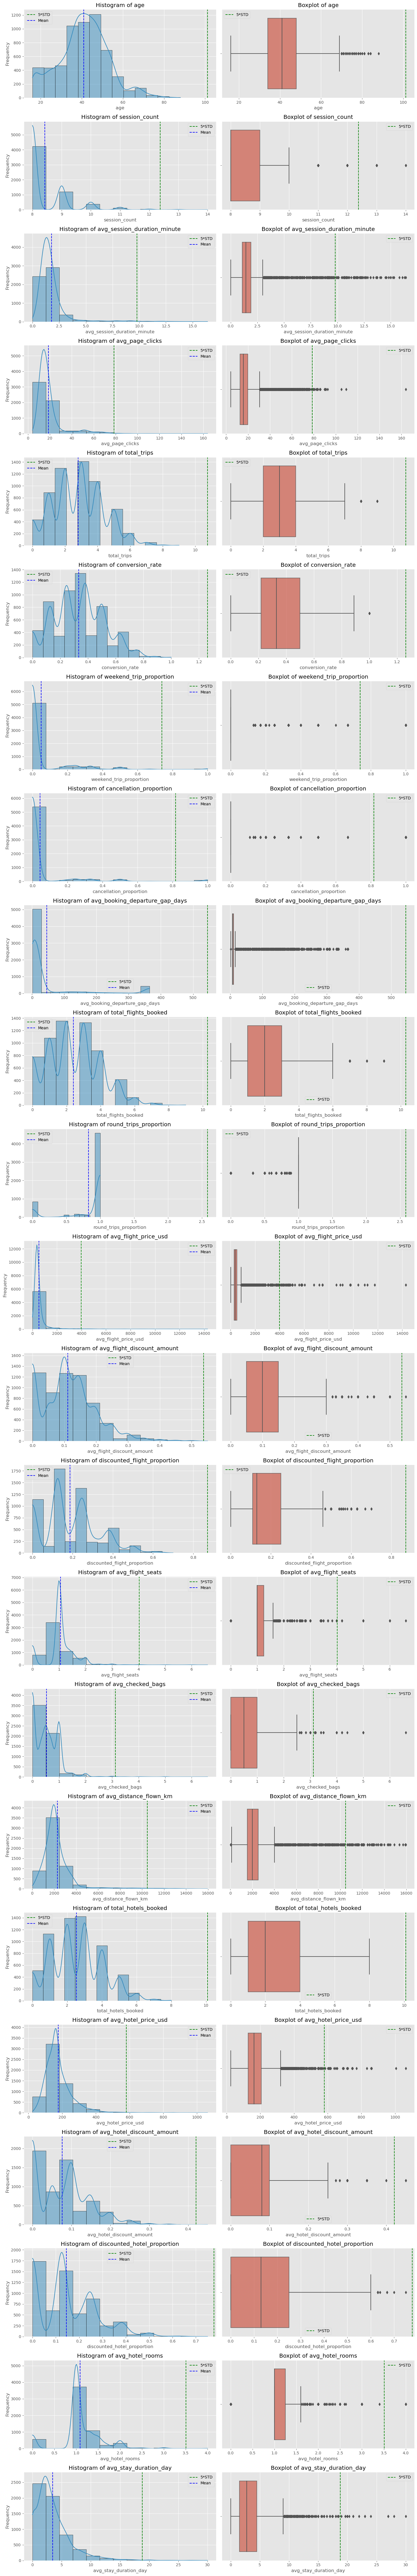

In [13]:
# Select only numerical columns and excluding the user_id column
numerical_columns = [col for col in cohort_users.select_dtypes(include=['float64', 'int64']).columns if col != 'user_id']


# Set up the figure and axes
fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(15, 4 * len(numerical_columns)))

for i, col in enumerate(numerical_columns):
    # Compute the outlier bounds: I commented out the lower_bound as in all the columns it's out of the range
    #lower_bound = cohort_users[col].mean() - 5 * cohort_users[col].std()
    upper_bound = cohort_users[col].mean() + 5 * cohort_users[col].std()
    mean = cohort_users[col].mean()
    
    # Plot histogram
    bins = int(np.log2(len(cohort_users[col])) + 1)  # Sturges' formula
    sns.histplot(cohort_users[col], ax=axes[i, 0], bins=bins, kde=True, edgecolor='black')
    axes[i, 0].set_title(f'Histogram of {col}')
    #axes[i, 0].axvline(lower_bound, color='r', linestyle='--', label=f'-5*STD')
    axes[i, 0].axvline(upper_bound, color='g', linestyle='--', label=f'5*STD') # Draw the 5*STD line on boxplot
    axes[i, 0].axvline(mean, color='b', linestyle='--', label='Mean')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].legend()
    
    # Plot box plot
    sns.boxplot(x=cohort_users[col], ax=axes[i, 1], showfliers=True, boxprops=dict(alpha=0.7))
    #axes[i, 1].axvline(upper_bound, color='r', linestyle='--', label=f'-5*STD')  # Draw the -5*STD line on boxplot
    axes[i, 1].axvline(upper_bound, color='g', linestyle='--', label=f'5*STD')  # Draw the 5*STD line on boxplot
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Few important notes to take:
* These visualizations provided valuable insights into the distribution of the data, helping us make informed decisions for our analysis.
* Using a threshold of __5*STD__ is quite lenient, and values beyond this range are highly likely to be outliers.
* There are multiple columns with data points beyond the 5*STD threshold.
* Some columns, like `avg_session_duration_minute`, have a significant proportion of their data points beyond this threshold.

## <font color=#DA70D6>Data Masking for Outlier Removal:</font>

I utilize a masking technique to streamline our outlier filtering process:

* I initiate a universal mask where all data points are considered valid (all set to True).
* For each column, a column-specific mask is created based on outlier detection.
* This column-specific mask is then combined with the universal mask to continuously refine our selection.
* Only data points that remain True across all columns are retained, ensuring a comprehensive filtering of outliers.

This approach ensures robust outlier removal while preserving the integrity of our core data.

In [14]:
# Select only numerical columns and excluding the user_id column
numerical_cols = [col for col in cohort_users.select_dtypes(include=['float64', 'int64']).columns if col != 'user_id']

# Initialize a mask with all True values
mask = pd.Series([True] * len(cohort_users))

for col in numerical_cols:
    mean_value = cohort_users[col].mean()
    std_value = cohort_users[col].std()
    lower_bound = mean_value - 5 * std_value
    upper_bound = mean_value + 5 * std_value 
    
    # Update the mask for this column
    column_mask = (cohort_users[col] >= lower_bound) & (cohort_users[col] <= upper_bound)
    mask &= column_mask
    
# Filter the data using the combined mask
cohort_users = cohort_users[mask]

In [15]:
# we had 5998 records
number_of_outliers = 5998 - cohort_users.shape[0]
percentage = round(number_of_outliers/5998 * 100,2)
print(f'{number_of_outliers} ({percentage}%) records were outliers!')

329 (5.49%) records were outliers!


## <font color=#DA70D6> Scaling:</font>

Before moving forward and creating new metrics, it makes sense to consider rescaling all numerical features to the same range for consistency. This way we ensure that each feature contributes equally to the computation, preventing any one feature from dominating due to its scale. We will use the **StandardScaler** method for rescaling.

However, before applying this transformation, it's crucial to note:
* The transformed values can sometimes be harder to interpret as they no longer represent the original units or scale, this is why we keep the original columns and will add a __"scaled"__ version of each to our dataset.
* The transformed values might have a mean that is not exactly 0 and a standard deviation that is not exactly 1, as StandardScaler scales features based on mean and standard deviation.
* The use of StandardScaler allows us to work with features that are centered around 0, which can be helpful for certain analyses. Since we've already treated outliers, this method should work well in ensuring that our features are properly scaled and ready for segmentation without being overly influenced by outliers.

In [16]:
# List of columns to scale 
cols_to_scale = ['married', 'has_children', 'age', 'session_count', 'avg_session_duration_minute', 'avg_page_clicks', 
                 'total_trips', 'conversion_rate', 'weekend_trip_proportion', 'cancellation_proportion', 
                 'avg_booking_departure_gap_days', 'total_flights_booked', 'round_trips_proportion', 
                 'avg_flight_price_usd', 'avg_flight_discount_amount', 'discounted_flight_proportion', 'avg_flight_seats', 
                 'avg_checked_bags', 'avg_distance_flown_km', 'total_hotels_booked', 'avg_hotel_price_usd',
                 'avg_hotel_discount_amount', 'discounted_hotel_proportion', 'avg_hotel_rooms', 'avg_stay_duration_day']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling and create new columns with suffix "_scaled"
scaled_data = scaler.fit_transform(cohort_users[cols_to_scale])
scaled_columns = ["scaled_" + col for col in cols_to_scale]
cohort_users[scaled_columns] = scaled_data.round(2)

# check the dataset 
cohort_users.head()

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,session_count,avg_session_duration_minute,avg_page_clicks,total_trips,conversion_rate,weekend_trip_proportion,cancellation_proportion,avg_booking_departure_gap_days,total_flights_booked,round_trips_proportion,avg_flight_price_usd,avg_flight_discount_amount,discounted_flight_proportion,avg_flight_seats,avg_checked_bags,avg_distance_flown_km,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,has_booked,has_booked_flight,has_booked_hotel,scaled_married,scaled_has_children,scaled_age,scaled_session_count,scaled_avg_session_duration_minute,scaled_avg_page_clicks,scaled_total_trips,scaled_conversion_rate,scaled_weekend_trip_proportion,scaled_cancellation_proportion,scaled_avg_booking_departure_gap_days,scaled_total_flights_booked,scaled_round_trips_proportion,scaled_avg_flight_price_usd,scaled_avg_flight_discount_amount,scaled_discounted_flight_proportion,scaled_avg_flight_seats,scaled_avg_checked_bags,scaled_avg_distance_flown_km,scaled_total_hotels_booked,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day
0,23557,2021-07-22,64,F,True,False,usa,new york,12,6.93,17.50,4,0.33,0.00,0.25,248.05,2,1.0,518.29,0.15,0.21,1.00,1.00,2680.73,4,157.33,0.18,0.29,1.33,7.33,True,True,True,1.13,-0.69,1.93,4.81,4.98,-0.04,0.73,-0.05,-0.38,2.59,2.07,-0.27,0.5,0.15,0.46,0.21,-0.06,1.10,0.45,0.95,-0.24,1.52,1.22,0.52,1.44
1,94883,2022-02-07,51,F,True,False,usa,kansas city,12,0.50,8.33,3,0.25,0.00,0.00,60.98,3,1.0,1784.95,0.10,0.08,1.67,1.00,5057.35,2,90.00,0.08,0.17,1.50,0.50,True,True,True,1.13,-0.69,0.84,4.81,-1.06,-0.92,0.10,-0.48,-0.38,-0.26,0.18,0.36,0.5,3.62,-0.13,-0.75,1.23,1.10,2.51,-0.37,-1.16,0.06,0.24,0.89,-1.03
3,101961,2022-02-17,42,F,True,False,usa,boston,12,2.00,18.17,7,0.58,0.14,0.00,7.34,6,1.0,321.53,0.13,0.25,1.00,0.50,1753.36,7,150.29,0.10,0.08,1.00,3.14,True,True,True,1.13,-0.69,0.07,4.81,0.35,0.03,2.61,1.29,0.82,-0.26,-0.36,2.26,0.5,-0.39,0.22,0.51,-0.06,-0.00,-0.35,2.94,-0.34,0.35,-0.49,-0.19,-0.08
9,149058,2022-04-14,50,F,False,True,usa,birmingham,12,2.79,15.36,6,0.50,0.00,0.17,58.79,6,1.0,664.40,0.05,0.21,1.56,0.67,2304.81,6,165.67,0.00,0.14,1.11,8.56,True,True,True,-0.89,1.45,0.75,4.81,1.09,-0.24,1.99,0.86,-0.38,1.68,0.16,2.26,0.5,0.55,-0.72,0.21,1.01,0.37,0.13,2.28,-0.13,-1.11,0.00,0.05,1.88
10,152583,2022-04-17,37,F,False,False,usa,colorado springs,10,6.17,21.25,2,0.20,0.00,0.50,181.16,2,1.0,3769.43,0.15,0.25,1.80,1.20,10253.52,2,213.00,0.15,0.42,1.00,2.00,True,True,True,-0.89,-0.69,-0.35,2.13,4.27,0.33,-0.53,-0.75,-0.38,5.43,1.40,-0.27,0.5,9.06,0.46,0.51,1.47,1.54,6.99,-0.37,0.52,1.08,2.27,-0.19,-0.49


## <font color=#DA70D6>Creating new metrics:</font>

Looking at our table, let's see which fields carry information about behaviour that might be relevant to our hypothesized perks. We need to know for each perk, what kind of travel behaviour indicates affinity to the perk. We already have some metrics that will be useful for further analysis of customer segmentation and perks offering. Let's first take a look at them, and then decide what more metrics we can calculate before moving forward:

### <font color=#52009D>1. Free hotel meal:</font> 

- __Families__, especially those with __children__, and __large tour groups__ might prefer the convenience of a hotel meal to simplify logistics and keep meals consistent.
- __Elderly Travelers__ might prefer the convenience and safety of dining in the hotel rather than venturing out, especially in the evening.

**Relevant Metrics:**
`age`, `has_children`, `avg_flight_seats`, `avg_checked_bags`, and `avg_hotel_rooms` 

### Metric to calculate: <font color=#52009D>free_meal_index</font> 

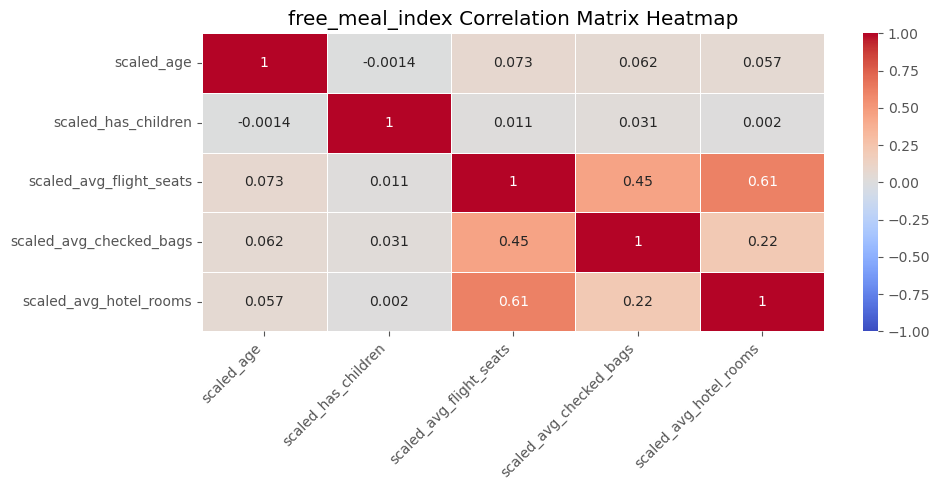

In [17]:
# Defining the correlation_columns list
free_meal_correlation_columns = ['scaled_age', 'scaled_has_children', 'scaled_avg_flight_seats', 
                                'scaled_avg_checked_bags', 'scaled_avg_hotel_rooms']

# Compute the correlation matrix for the free_meal_index
correlation_matrix = cohort_users[free_meal_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("free_meal_index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

### Observations from the "free_meal_index" Correlation Matrix:**

`scaled_age` correlation with all other metrics is **low** and indicates that age does not have a strong linear relationship with any of the other variables we're considering.

`has_children` correlation with other metrics are also **very weak** and indicates that while having children might be relevant from a business perspective, it doesn't have a strong linear relationship with other variables. However, its binary nature might impact its correlation magnitude with other scaled metrics.

`scaled_avg_flight_seats` has a **moderate** correlation with `scaled_avg_checked_bags` and a **strong** correlation with `scaled_avg_hotel_rooms`. This suggests that the more flight seats a user books, the more likely they are to also book more hotel rooms and have more checked bags. This might indicate group or family travel.

`scaled_avg_checked_bags` and `scaled_avg_hotel_rooms` have **weak to moderate** relationship. This indicates some relationship between the number of checked bags and the number of hotel rooms, but not as strong as one might expect.

**Calculate the free_meal_index:**

Given our goal and the nature of these correlations, a **weighted average** can be a good approach. Since all metrics are in our favor and have been scaled, the weight will determine the importance of each metric in the final index.

I will place more weight on `scaled_avg_flight_seats` and less `scaled_avg_hotel_rooms` because of their strong correlation. This suggests they are good predictors of **group travel**, which aligns well with the target segment for the hotel meal perk.

`has_children` and `scaled_age` can have a lesser weight since their correlations are all very weak.

`scaled_avg_checked_bags` can have a moderate weight.

In [18]:
# Define the weights for each feature
weights = {
    'scaled_age': 0.1,
    'scaled_has_children': 0.1,
    'scaled_avg_flight_seats': 0.4,
    'scaled_avg_checked_bags': 0.2,
    'scaled_avg_hotel_rooms': 0.2
}

# Initialize the free_meal_index column to 0
cohort_users['free_meal_index'] = 0

# Calculate the free_meal_index using the weighted average
for column, weight in weights.items():
    cohort_users['free_meal_index'] += cohort_users[column] * weight

### <font color=#52009D>2. Free checked bags:</font> 
* __Long-Term Travelers__ tend to have more luggage.
* __Travelers covering long distances___ often stay at their destinations for extended periods, requiring them to pack more items for a variety of situations and potentially different climates.  They might carry gifts/souvenirs with them. 
* __Families__ might have extra luggage, especially when travelling with children (strollers, toys, etc.).
* __Travelers Booking Round Trips__ usually prefer for convenience and predictability. Having a free checked bag aligns with this mindset, offering a hassle-free experience by eliminating potential additional costs or decisions about luggage on both legs of their journey.

**Relevant Metrics:** `avg_stay_duration_day`, `avg_distance_flown_km`, `has_children`, `avg_checked_bags`, and `round_trips_proportion`

### Metric to calculate: <font color=#52009D>free_bag_index</font>

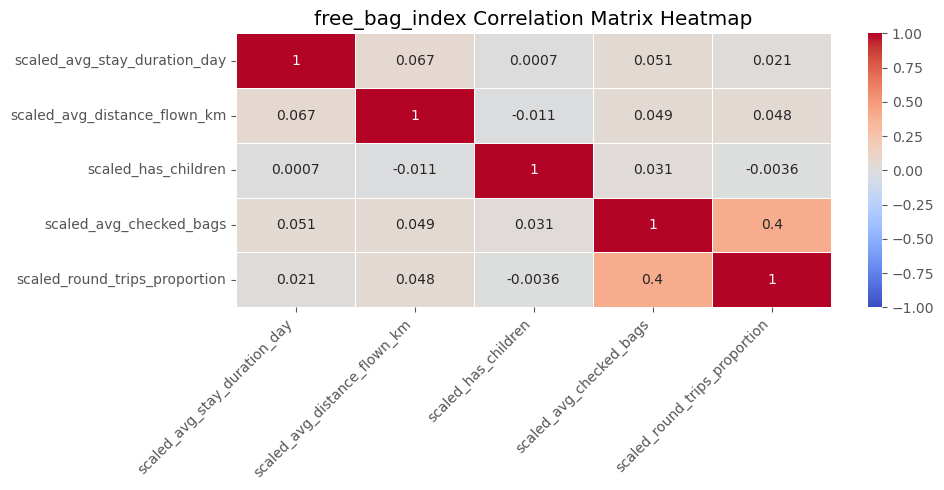

In [19]:
# Defining the correlation_columns list
free_bag_correlation_columns = ['scaled_avg_stay_duration_day', 'scaled_avg_distance_flown_km', 
                                'scaled_has_children', 'scaled_avg_checked_bags', 'scaled_round_trips_proportion']
    

# Compute the correlation matrix for the free_bag_index
correlation_matrix = cohort_users[free_bag_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("free_bag_index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

### Observations from the "free_bag_index" Correlation Matrix:

The correlation between `scaled_avg_checked_bag` and `round_trip_proportion` stands out as the **strongest** and is meaningful from a business perspective.

Most of the other correlations are **weak**, but given the business context, they might still be significant for the index. Even with weak correlations, `has_children` might be an essential metric due to its business significance.

A **weighted average** can be a good method to calculate the index.

In [20]:
# Define the weights for each feature
weights = {
    'scaled_avg_stay_duration_day': 0.20,
    'scaled_avg_distance_flown_km': 0.10,
    'scaled_has_children': 0.2,
    'scaled_avg_checked_bags': 0.40,
    'scaled_round_trips_proportion': 0.10
}


# Calculate the free_bag_index using the weighted average
cohort_users['free_bag_index'] = 0  # initialize the index column to 0

for column, weight in weights.items():
    cohort_users['free_bag_index'] += cohort_users[column] * weight

### <font color=#52009D>3. No cancellation fees:</font> 

* __Uncertain Travelers__ who aren’t sure about their plans or are booking well in advance might value this perk.
* __Travelers with a High Number of Cancelled Trips__ are likely value flexibility in future bookings to avoid incurring costs.

**Relevant Metrics:** `avg_booking_departure_gap_days` and `cancellations_proportion`

### Metric to calculate: <font color=#52009D>last_min_booker_index</font>

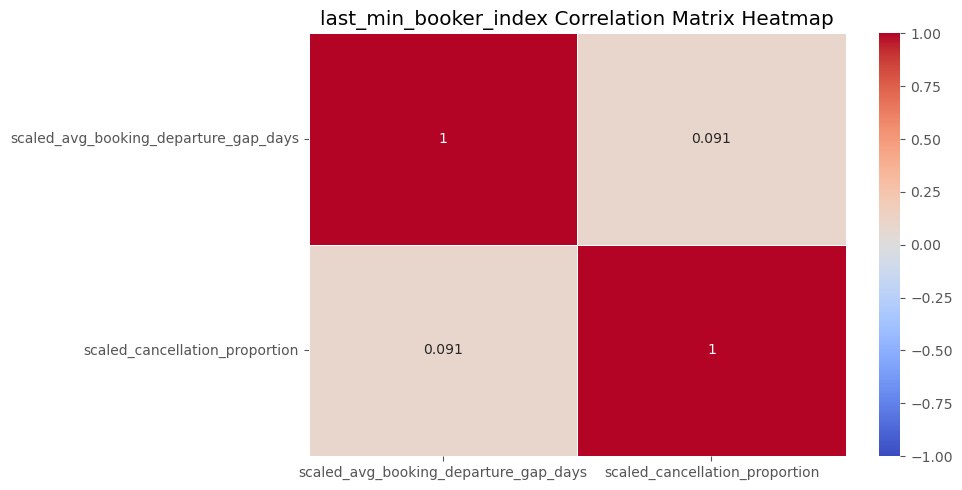

In [21]:
# Defining the correlation_columns list
last_min_correlation_columns = ['scaled_avg_booking_departure_gap_days', 'scaled_cancellation_proportion']
    
# Compute the correlation matrix for the last_min_booker_index
scaled_correlation_matrix = cohort_users[last_min_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(scaled_correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Set the title and show the plot
plt.title("last_min_booker_index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

### Observations from the "last_min_booker_index" Correlation Matrix:

The **correlation coefficient** of **0.091** between the two metrics suggests a **very weak positive** linear relationship, which means that the two metrics are capturing somewhat different aspects of the behavior, which is good for differentiation. If they were highly correlated, they'd be redundant.

Our analysis indicates two primary user behavior types:

1. **Planning in Advance:** Users with longer average booking departure gaps tend to plan their trips well in advance. This may indicate they are less likely to cancel bookings due to more concrete travel plans.
2. **Low Cancellation Propensity:** Users with lower cancellation proportions are less likely to cancel bookings, suggesting a stronger commitment to travel plans.

Since both columns are already scaled, we can directly use them in our index calculation using **weighted average** method.

In [22]:
# Define weights
w1 = 0.5  # Weight for scaled_cancellation_proportion
w2 = 0.5  # Weight for scaled_avg_booking_departure_gap_days

'''
Subtracting the scaled_avg_booking_departure_gap_days from max_value will ensure that 
lower values (indicating last-minute booking) contribute more to the index.
'''
# Calculate the last_min_booker_index using the weighted average
max_gap = cohort_users['scaled_avg_booking_departure_gap_days'].max()

cohort_users['last_min_booker_index'] = w1 * cohort_users['scaled_cancellation_proportion'] + w2 * (max_gap - cohort_users['scaled_avg_booking_departure_gap_days'])  

### <font color=#52009D>4. Exclusive discounts:</font> 

This one is a bit unclear compared to the other perks. Based on what the Marketing Manager said, we're looking for **price-sensitive customers.**

**Relevant Metrics:** 

`conversion_rate`: A low conversion rate, indicating unwillingness to buy except at a low enough price
`avg_session_duration_minute` and `avg_page_clicks`: Longer values might indicate bargain-hunting behaviour
`avg_flight_discount_amount`, `discounted_flight_proportion`, `avg_hotel_discount_amount` and `discounted_hotel_proportion`

### Metric to calculate: <font color=#52009D>bargain_hunter_index</font>
But first we will calculate another metric, `average_dollar_saved_per_km`

In [23]:
# Caluculating the average_dollar_saved_per_kilometre metric 
avg_usd_saved_per_km = round(cohort_users['avg_flight_discount_amount'] 
                                                    * cohort_users['avg_flight_price_usd'] 
                                                    / cohort_users['avg_distance_flown_km'],2)

# Determine the position to insert the new column after the last_min_booking columns
position = cohort_users.columns.get_loc('avg_distance_flown_km') + 1

# Insert the new column which is the maximum of the both columns at the desired position
cohort_users.insert(position, 'avg_usd_saved_per_km', avg_usd_saved_per_km)

# Initialize the StandardScaler to scale the new metric
scaler = StandardScaler()

# Reshape the data to a 2D array-like structure as StandardScaler expects
# Each row corresponds to a sample and each column corresponds to a feature
scaled_data = avg_usd_saved_per_km.values.reshape(-1, 1)

# Apply scaling and create a new column with suffix "_scaled"
scaled_data = scaler.fit_transform(scaled_data)
cohort_users['scaled_avg_usd_saved_per_km'] = scaled_data.round(2)

# Determine the position to insert the new scaled column after the scaled_avg_stay_duration_day column
# It's just a personal preference as I want to have all the scaled columns next to each other 
scaled_position = cohort_users.columns.get_loc('scaled_avg_stay_duration_day') + 1

# Insert the new scaled column after the scaled_avg_stay_duration_day column
cohort_users.insert(scaled_position, 'scaled_avg_usd_saved_per_km', cohort_users.pop('scaled_avg_usd_saved_per_km'))

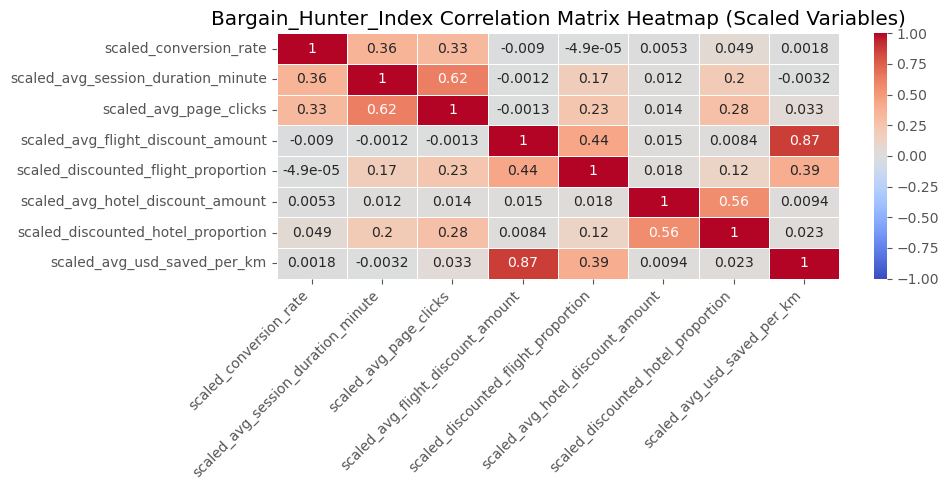

In [24]:
# Defining the correlation_columns list
bargain_correlation_columns = [
    'scaled_conversion_rate',
    'scaled_avg_session_duration_minute',
    'scaled_avg_page_clicks',
    'scaled_avg_flight_discount_amount',
    'scaled_discounted_flight_proportion',
    'scaled_avg_hotel_discount_amount',
    'scaled_discounted_hotel_proportion',
    'scaled_avg_usd_saved_per_km'
]
    
# Compute the correlation matrix for the bargain_hunter_index relevant metrics using the scaled columns
scaled_correlation_matrix = cohort_users[bargain_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(scaled_correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("Bargain_Hunter_Index Correlation Matrix Heatmap (Scaled Variables)")
plt.tight_layout()
plt.show()

### Observations from the Correlation Matrix:

`scaled_conversation_rate` has __moderate positive__ correlations with `scaled_avg_session_duration_minute` and `scaled_avg_page_clicks`. This indicates that customers who spend more time on the platform and click on more pages tend to convert less frequently, which is consistent with them being more price-sensitive. The correlations between `scaled_conversion_rate` and the rest of features are all __very weak__, suggesting that these direct price-related features may not individually explain conversion behavior well.

There's a strong correlation between `scaled_avg_session_duration_minute` and `scaled_avg_page_clicks`, implying users who spend more time on the site tend to click on more pages. 

Among all the price-related features, the strongest correlation is between `scaled_avg_flight_discount_amount` and `scaled_avg_usd_saved_per_km`. This indicates that the customers who tend to get higher flight discounts also tend to save more per kilometer, not a surprise as the avg_usd_saved is the product of `scaled_avg_flight_discount_amount`. So I will remove `avg_flight_discount_amount` from the index calculation.
    
`scaled_avg_page_clicks` has __moderate positive__ correlations with `scaled_discounted_flight_proportion` and `scaled_discounted_hotel_proportion`. This suggests that customers clicking more pages may be actively searching for discounts.
    
The **bargain_hunting_index** can be represented as a **weighted average** of the given metrics.

In [25]:
# Calculate the bargain_hunter_index using the weighted average
# Define the weights for each feature
weights = {
    'scaled_conversion_rate': 0.3,
    'scaled_avg_session_duration_minute': 0.2,
    'scaled_avg_page_clicks': 0.1,
    'scaled_discounted_flight_proportion': 0.1,
    'scaled_avg_hotel_discount_amount': 0.1,
    'scaled_discounted_hotel_proportion': 0.05,
    'scaled_avg_usd_saved_per_km': 0.15
}

# Calculate the bargain_hunting_index for each row
cohort_users['bargain_hunting_index'] = 0

for column, weight in weights.items():
    value = (1 - cohort_users[column]) if column == 'conversion_rate' else cohort_users[column]
    cohort_users['bargain_hunting_index'] += weight * value

### <font color=#52009D>5. 1-night free hotel with a flight:</font> 
* __Frequent Flyers__, especially those who often book __round trips__, would appreciate the added value of a free hotel night.
* __Short-Stay Travelers__ or __Weekend Getaway Travelers__ who typically book short stays might find this perk particularly enticing as it significantly reduces their accommodation cost.

**Relevant Metrics:** `total_flights_booked`, `weekend_trip_proportion`, `round_trips_proportion`,` total_hotels_booked`

### Metric to calculate: <font color=#52009D>free_hotel_index</font>

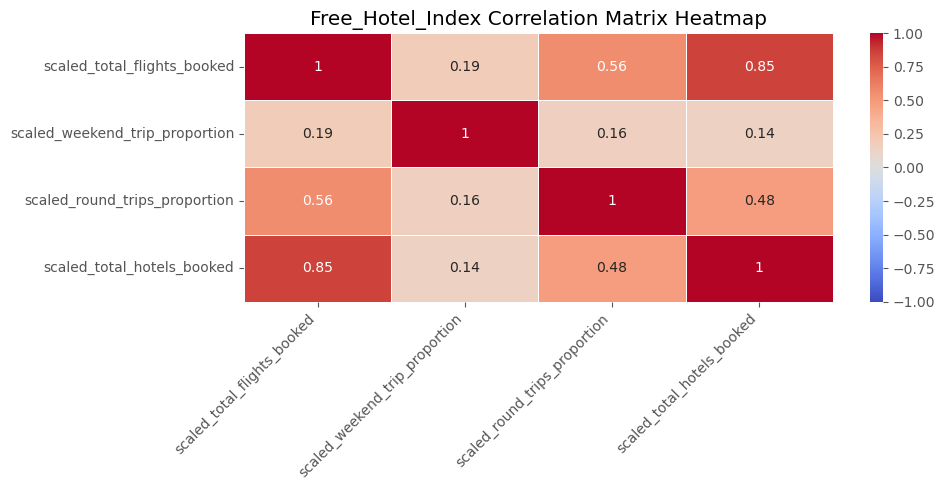

In [26]:
# Defining the correlation_columns list
hotel_correlation_columns = [
    'scaled_total_flights_booked',
    'scaled_weekend_trip_proportion',
    'scaled_round_trips_proportion',
    'scaled_total_hotels_booked'
]
    
# Compute the correlation matrix for the fee_hotel_index
correlation_matrix = cohort_users[hotel_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("Free_Hotel_Index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

### Observations from the "free_hotel_index" Correlation Matrix:

`scaled_total_flights_booked` has a **strong** correlation with `scaled_total_hotels_booked`, which makes sense — frequent flyers are likely to book hotels often. It also has a moderate correlation with `scaled_round_trips_proportion`, implying frequent flyers often book round trips. 

`scaled_weekend_trip_proportion` shows **weak** correlation with the other metrics.

`scaled_round_trips_proportion` has a **moderate** correlation with `scaled_total_flights_booked` and `scaled_total_hotels_booked` suggests that travelers booking round trips also often book flights and hotels together.

* The **strong correlation** between `scaled_total_flights_booked` and `scaled_total_hotels_booked` indicates that frequent flyers often book hotels. This connection is a critical insight for the **1-night free hotel** with a flight" perk.

* The **moderate correlations** involving `scaled_round_trips_proportion` indicate the relevance of round trip bookings in the context of this perk.

I will use **weighted average** to calculate this metric.

In [27]:
# Calculate the free_hotel_index using the weighted average
# Define the weights for each feature
weights = {
    'scaled_total_flights_booked': 0.35,
    'scaled_weekend_trip_proportion': 0.15,
    'scaled_round_trips_proportion': 0.25,
    'scaled_total_hotels_booked': 0.25
}


# Initialize the free_hotel_index column to 0
cohort_users['free_hotel_index'] = 0

# Calculate the free_hotel_index for each row
for column, weight in weights.items():
    cohort_users['free_hotel_index'] += cohort_users[column] * weight

# Verify the creation of all the indexes
cohort_users.head()

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,session_count,avg_session_duration_minute,avg_page_clicks,total_trips,conversion_rate,weekend_trip_proportion,cancellation_proportion,avg_booking_departure_gap_days,total_flights_booked,round_trips_proportion,avg_flight_price_usd,avg_flight_discount_amount,discounted_flight_proportion,avg_flight_seats,avg_checked_bags,avg_distance_flown_km,avg_usd_saved_per_km,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,has_booked,has_booked_flight,has_booked_hotel,scaled_married,scaled_has_children,scaled_age,scaled_session_count,scaled_avg_session_duration_minute,scaled_avg_page_clicks,scaled_total_trips,scaled_conversion_rate,scaled_weekend_trip_proportion,scaled_cancellation_proportion,scaled_avg_booking_departure_gap_days,scaled_total_flights_booked,scaled_round_trips_proportion,scaled_avg_flight_price_usd,scaled_avg_flight_discount_amount,scaled_discounted_flight_proportion,scaled_avg_flight_seats,scaled_avg_checked_bags,scaled_avg_distance_flown_km,scaled_total_hotels_booked,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day,scaled_avg_usd_saved_per_km,free_meal_index,free_bag_index,last_min_booker_index,bargain_hunting_index,free_hotel_index
0,23557,2021-07-22,64,F,True,False,usa,new york,12,6.93,17.50,4,0.33,0.00,0.25,248.05,2,1.0,518.29,0.15,0.21,1.00,1.00,2680.73,0.03,4,157.33,0.18,0.29,1.33,7.33,True,True,True,1.13,-0.69,1.93,4.81,4.98,-0.04,0.73,-0.05,-0.38,2.59,2.07,-0.27,0.5,0.15,0.46,0.21,-0.06,1.10,0.45,0.95,-0.24,1.52,1.22,0.52,1.44,0.31,0.424,0.685,1.890,1.2575,0.2110
1,94883,2022-02-07,51,F,True,False,usa,kansas city,12,0.50,8.33,3,0.25,0.00,0.00,60.98,3,1.0,1784.95,0.10,0.08,1.67,1.00,5057.35,0.04,2,90.00,0.08,0.17,1.50,0.50,True,True,True,1.13,-0.69,0.84,4.81,-1.06,-0.92,0.10,-0.48,-0.38,-0.26,0.18,0.36,0.5,3.62,-0.13,-0.75,1.23,1.10,2.51,-0.37,-1.16,0.06,0.24,0.89,-1.03,0.79,0.905,0.397,1.410,-0.3865,0.1015
3,101961,2022-02-17,42,F,True,False,usa,boston,12,2.00,18.17,7,0.58,0.14,0.00,7.34,6,1.0,321.53,0.13,0.25,1.00,0.50,1753.36,0.02,7,150.29,0.10,0.08,1.00,3.14,True,True,True,1.13,-0.69,0.07,4.81,0.35,0.03,2.61,1.29,0.82,-0.26,-0.36,2.26,0.5,-0.39,0.22,0.51,-0.06,-0.00,-0.35,2.94,-0.34,0.35,-0.49,-0.19,-0.08,-0.17,-0.124,-0.139,1.680,0.4960,1.7740
9,149058,2022-04-14,50,F,False,True,usa,birmingham,12,2.79,15.36,6,0.50,0.00,0.17,58.79,6,1.0,664.40,0.05,0.21,1.56,0.67,2304.81,0.01,6,165.67,0.00,0.14,1.11,8.56,True,True,True,-0.89,1.45,0.75,4.81,1.09,-0.24,1.99,0.86,-0.38,1.68,0.16,2.26,0.5,0.55,-0.72,0.21,1.01,0.37,0.13,2.28,-0.13,-1.11,0.00,0.05,1.88,-0.65,0.708,0.877,2.390,0.2645,1.4290
10,152583,2022-04-17,37,F,False,False,usa,colorado springs,10,6.17,21.25,2,0.20,0.00,0.50,181.16,2,1.0,3769.43,0.15,0.25,1.80,1.20,10253.52,0.06,2,213.00,0.15,0.42,1.00,2.00,True,True,True,-0.89,-0.69,-0.35,2.13,4.27,0.33,-0.53,-0.75,-0.38,5.43,1.40,-0.27,0.5,9.06,0.46,0.51,1.47,1.54,6.99,-0.37,0.52,1.08,2.27,-0.19,-0.49,1.76,0.754,1.129,3.645,1.1985,-0.1190


## <font color=#DA70D6>Segmenting customers by Fuzzy Segmentation:</font>

In [28]:
# Select only indexes columns
indexes_columns = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 
                   'bargain_hunting_index', 'free_hotel_index']

indexes = cohort_users[indexes_columns]
indexes.head()

,free_meal_index,free_bag_index,last_min_booker_index,bargain_hunting_index,free_hotel_index
0,0.424,0.685,1.890,1.2575,0.2110
1,0.905,0.397,1.410,-0.3865,0.1015
3,-0.124,-0.139,1.680,0.4960,1.7740
9,0.708,0.877,2.390,0.2645,1.4290
10,0.754,1.129,3.645,1.1985,-0.1190


In [29]:
indexes.describe().T

,count,mean,std,min,25%,50%,75%,max
free_meal_index,5669.0,-0.000938,0.678646,-1.7590,-0.2330,0.029,0.325,3.995
free_bag_index,5669.0,0.000494,0.560354,-1.1250,-0.3570,-0.019,0.333,3.046
last_min_booker_index,5669.0,1.629603,0.674494,-0.1300,1.6700,1.680,1.685,4.555
bargain_hunting_index,5669.0,-0.000102,0.560332,-1.4330,-0.3785,-0.032,0.326,2.837
free_hotel_index,5669.0,0.000463,0.787699,-1.6035,-0.3430,0.046,0.523,2.706


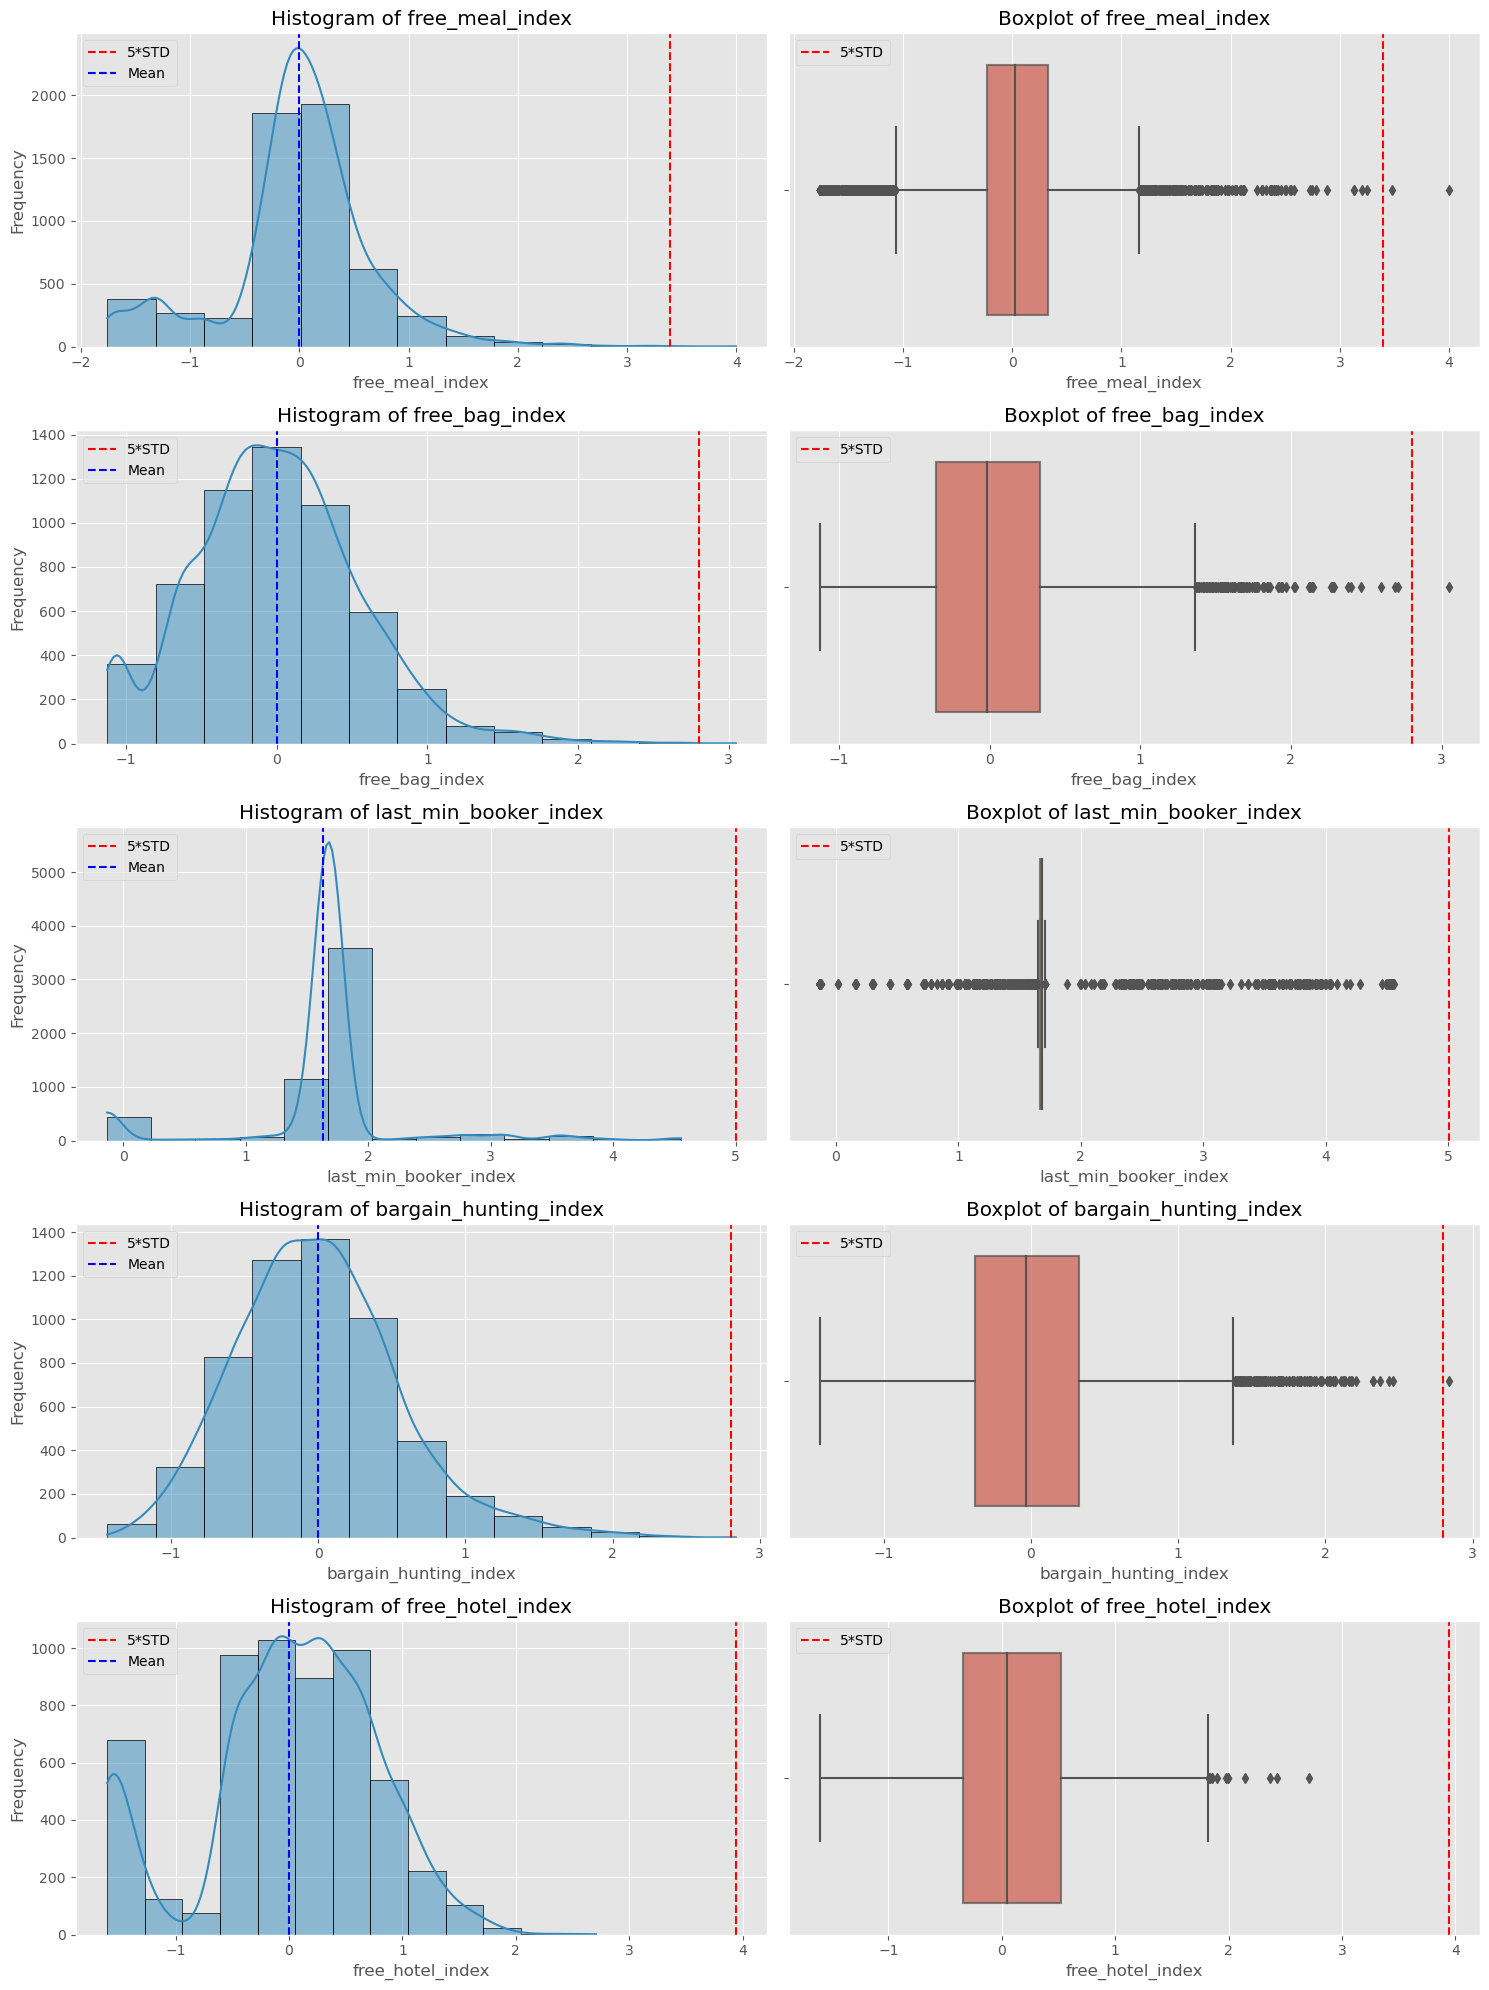

In [30]:
# Set up the figure and axes
fig, axes = plt.subplots(len(indexes_columns), 2, figsize=(15, 4 * len(indexes_columns)))

for i, col in enumerate(indexes_columns):
    # Compute the outlier bounds: I commented out the lower_bound as in all the columns it's out of the range
    #lower_bound = cohort_users[col].mean() - 5 * cohort_users[col].std()
    upper_bound = cohort_users[col].mean() + 5 * cohort_users[col].std()
    mean = cohort_users[col].mean()
    
    # Plot histogram
    bins = int(np.log2(len(indexes[col])) + 1)  # Sturges' formula
    sns.histplot(indexes[col], ax=axes[i, 0], bins=bins, kde=True, edgecolor='black')
    axes[i, 0].set_title(f'Histogram of {col}')
    #axes[i, 0].axvline(lower_bound, color='r', linestyle='--', label=f'-5*STD')
    axes[i, 0].axvline(upper_bound, color='r', linestyle='--', label=f'5*STD')
    axes[i, 0].axvline(mean, color='b', linestyle='--', label='Mean')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].legend()
    
    # Plot box plot
    sns.boxplot(x=indexes[col], ax=axes[i, 1], showfliers=True, boxprops=dict(alpha=0.7))
    #axes[i, 1].axvline(lower_bound, color='r', linestyle='--', label=f'-5*STD')  # Draw the 5*STD line on boxplot
    axes[i, 1].axvline(upper_bound, color='r', linestyle='--', label=f'5*STD')  # Draw the 5*STD line on boxplot
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## <font color=#DA70D6>Ranking Perk Indexes</font> 
For each perk, we'll perform the following tasks:

* Sort the dataset by the respective perk index in descending order.
* Assign ranks starting from 1 to N, where N is the total number of customers.

In [31]:
# Importing the rank function from pandas
from pandas import DataFrame

# Initialize an empty DataFrame to store the ranks, setting user_id as the index for easier alignment
rank_df = DataFrame()
rank_df['user_id'] = cohort_users['user_id']
rank_df.set_index('user_id', inplace=True)

# List of perk indexes
perk_indexes = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 'bargain_hunting_index', 'free_hotel_index']

# Loop through each perk index to sort and rank
for perk in perk_indexes:
    # Sort by the perk index and reset the index
    sorted_data = cohort_users.sort_values(by=[perk], ascending=False).reset_index(drop=True)
    
    # Assign rank starting from 1 to N
    sorted_data[f'{perk}_rank'] = sorted_data.index + 1
    
    # Align the ranks with the original user_id and store them in the rank DataFrame
    rank_df[f'{perk}_rank'] = sorted_data.set_index('user_id')[f'{perk}_rank']

    
# Reset the index for the final DataFrame
rank_df.reset_index(inplace=True)
    
# Display the first few rows of the rank DataFrame
rank_df.head()

,user_id,free_meal_index_rank,free_bag_index_rank,last_min_booker_index_rank,bargain_hunting_index_rank,free_hotel_index_rank
0,23557,1110,596,404,156,2540
1,94883,376,1211,5091,4278,2698
2,101961,3710,3344,2330,906,21
3,149058,594,328,378,1629,115
4,152583,528,165,82,178,3670


## <font color=#DA70D6>Ranking Perk Indexes</font> 

For each customer, we now have the following rank columns:

* free_meal_index_rank
* free_bag_index_rank
* last_min_booker_index_rank
* bargain_hunting_index_rank
* free_hotel_index_rank

The rank starts from 1, indicating the highest affinity for a particular perk, and goes up to N, where N is the total number of customers.

## <font color=#DA70D6>Find Minimum Rank Perk for Each Customer</font> 

The next step is to find out which perk has the minimum rank for each customer. The perk with the lowest rank will be the one that the customer most belongs to. Let's proceed with this step.

In [32]:
# Calculate the minimum rank for each customer and the corresponding perk index
rank_df['min_rank'] = rank_df.iloc[:, 1:].min(axis=1)
rank_df['best_index'] = rank_df.iloc[:, 1:].idxmin(axis=1).str.replace('_rank', '')

# Display the first few rows of the rank DataFrame with the min rank and best perk
rank_df.head()

,user_id,free_meal_index_rank,free_bag_index_rank,last_min_booker_index_rank,bargain_hunting_index_rank,free_hotel_index_rank,min_rank,best_index
0,23557,1110,596,404,156,2540,156,bargain_hunting_index
1,94883,376,1211,5091,4278,2698,376,free_meal_index
2,101961,3710,3344,2330,906,21,21,free_hotel_index
3,149058,594,328,378,1629,115,115,free_hotel_index
4,152583,528,165,82,178,3670,82,last_min_booker_index


## <font color=#DA70D6>Finding the Minimum Rank Perk</font> 

We have successfully identified the perk with the minimum rank for each customer. Two new columns have been added to the rank_df DataFrame:

* `min_rank`: Indicates the minimum rank among all the perks for each customer.
* `best_index`: Indicates the perk corresponding to the minimum rank.

This means the perk listed in **best_perk** is the one to which the customer most belongs, as per the fuzzy segmentation.

## <font color=#DA70D6>Summarize the Segmentation</font> 

To finalize, let's summarize the segmentation by counting how many customers are most inclined toward each perk. This will give us an idea of the distribution of perks among customers.

In [33]:
# Count the number of customers most inclined towards each perk
perk_distribution = rank_df['best_index'].value_counts().reset_index()
perk_distribution.columns = ['Best Index', 'Number of Customers']

# Create a dictionary to map the index names to the perk names
perk_names = {
    'free_meal_index': 'Free hotel meal',
    'free_bag_index': 'Free checked bag',
    'last_min_booker_index': 'No cancellation fees',
    'bargain_hunting_index': 'Exclusive discounts',
    'free_hotel_index': '1-night free hotel with a flight'
}

# Add a new column for the perk names
perk_distribution['Perk Name'] = perk_distribution['Best Index'].map(perk_names)

# Reorder columns for better readability
perk_distribution = perk_distribution[['Best Index', 'Perk Name', 'Number of Customers']]

# Display the updated distribution with perk names
perk_distribution

,Best Index,Perk Name,Number of Customers
0,last_min_booker_index,No cancellation fees,1289
1,free_bag_index,Free checked bag,1285
2,free_hotel_index,1-night free hotel with a flight,1165
3,bargain_hunting_index,Exclusive discounts,1040
4,free_meal_index,Free hotel meal,890


In [34]:
# Map the index names to the more descriptive perk names for segment labels
rank_df['segment_label'] = rank_df['best_index'].map(perk_names)

# Drop the 'best_index' column as we now have 'segment_label'
rank_df.drop(columns=['best_index'], inplace=True)

# Perform the join based on user_id
cohort_users = cohort_users.merge(rank_df[['user_id', 'segment_label']], on='user_id', how='left')

cohort_users.head()

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,session_count,avg_session_duration_minute,avg_page_clicks,total_trips,conversion_rate,weekend_trip_proportion,cancellation_proportion,avg_booking_departure_gap_days,total_flights_booked,round_trips_proportion,avg_flight_price_usd,avg_flight_discount_amount,discounted_flight_proportion,avg_flight_seats,avg_checked_bags,avg_distance_flown_km,avg_usd_saved_per_km,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,has_booked,has_booked_flight,has_booked_hotel,scaled_married,scaled_has_children,scaled_age,scaled_session_count,scaled_avg_session_duration_minute,scaled_avg_page_clicks,scaled_total_trips,scaled_conversion_rate,scaled_weekend_trip_proportion,scaled_cancellation_proportion,scaled_avg_booking_departure_gap_days,scaled_total_flights_booked,scaled_round_trips_proportion,scaled_avg_flight_price_usd,scaled_avg_flight_discount_amount,scaled_discounted_flight_proportion,scaled_avg_flight_seats,scaled_avg_checked_bags,scaled_avg_distance_flown_km,scaled_total_hotels_booked,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day,scaled_avg_usd_saved_per_km,free_meal_index,free_bag_index,last_min_booker_index,bargain_hunting_index,free_hotel_index,segment_label
0,23557,2021-07-22,64,F,True,False,usa,new york,12,6.93,17.50,4,0.33,0.00,0.25,248.05,2,1.0,518.29,0.15,0.21,1.00,1.00,2680.73,0.03,4,157.33,0.18,0.29,1.33,7.33,True,True,True,1.13,-0.69,1.93,4.81,4.98,-0.04,0.73,-0.05,-0.38,2.59,2.07,-0.27,0.5,0.15,0.46,0.21,-0.06,1.10,0.45,0.95,-0.24,1.52,1.22,0.52,1.44,0.31,0.424,0.685,1.890,1.2575,0.2110,Exclusive discounts
1,94883,2022-02-07,51,F,True,False,usa,kansas city,12,0.50,8.33,3,0.25,0.00,0.00,60.98,3,1.0,1784.95,0.10,0.08,1.67,1.00,5057.35,0.04,2,90.00,0.08,0.17,1.50,0.50,True,True,True,1.13,-0.69,0.84,4.81,-1.06,-0.92,0.10,-0.48,-0.38,-0.26,0.18,0.36,0.5,3.62,-0.13,-0.75,1.23,1.10,2.51,-0.37,-1.16,0.06,0.24,0.89,-1.03,0.79,0.905,0.397,1.410,-0.3865,0.1015,Free hotel meal
2,101961,2022-02-17,42,F,True,False,usa,boston,12,2.00,18.17,7,0.58,0.14,0.00,7.34,6,1.0,321.53,0.13,0.25,1.00,0.50,1753.36,0.02,7,150.29,0.10,0.08,1.00,3.14,True,True,True,1.13,-0.69,0.07,4.81,0.35,0.03,2.61,1.29,0.82,-0.26,-0.36,2.26,0.5,-0.39,0.22,0.51,-0.06,-0.00,-0.35,2.94,-0.34,0.35,-0.49,-0.19,-0.08,-0.17,-0.124,-0.139,1.680,0.4960,1.7740,1-night free hotel with a flight
3,149058,2022-04-14,50,F,False,True,usa,birmingham,12,2.79,15.36,6,0.50,0.00,0.17,58.79,6,1.0,664.40,0.05,0.21,1.56,0.67,2304.81,0.01,6,165.67,0.00,0.14,1.11,8.56,True,True,True,-0.89,1.45,0.75,4.81,1.09,-0.24,1.99,0.86,-0.38,1.68,0.16,2.26,0.5,0.55,-0.72,0.21,1.01,0.37,0.13,2.28,-0.13,-1.11,0.00,0.05,1.88,-0.65,0.708,0.877,2.390,0.2645,1.4290,1-night free hotel with a flight
4,152583,2022-04-17,37,F,False,False,usa,colorado springs,10,6.17,21.25,2,0.20,0.00,0.50,181.16,2,1.0,3769.43,0.15,0.25,1.80,1.20,10253.52,0.06,2,213.00,0.15,0.42,1.00,2.00,True,True,True,-0.89,-0.69,-0.35,2.13,4.27,0.33,-0.53,-0.75,-0.38,5.43,1.40,-0.27,0.5,9.06,0.46,0.51,1.47,1.54,6.99,-0.37,0.52,1.08,2.27,-0.19,-0.49,1.76,0.754,1.129,3.645,1.1985,-0.1190,No cancellation fees


## <font color=#DA70D6>Exploratory Data Analysis for Segmentation</font> 

Before moving on to the final step and export the customer segmentation csv file, it's crucial to perform some EDA to better understand the segmentation. This will help in validating the data and ensuring that the segments align with the proposed perks. It will also serve as a basis for providing evidence-based insights.

### Distribution of Customers Across Different Segments:
First, let's plot a bar chart to visualize how many customers belong to each segment. This will give us an overall idea of the segmentation distribution.

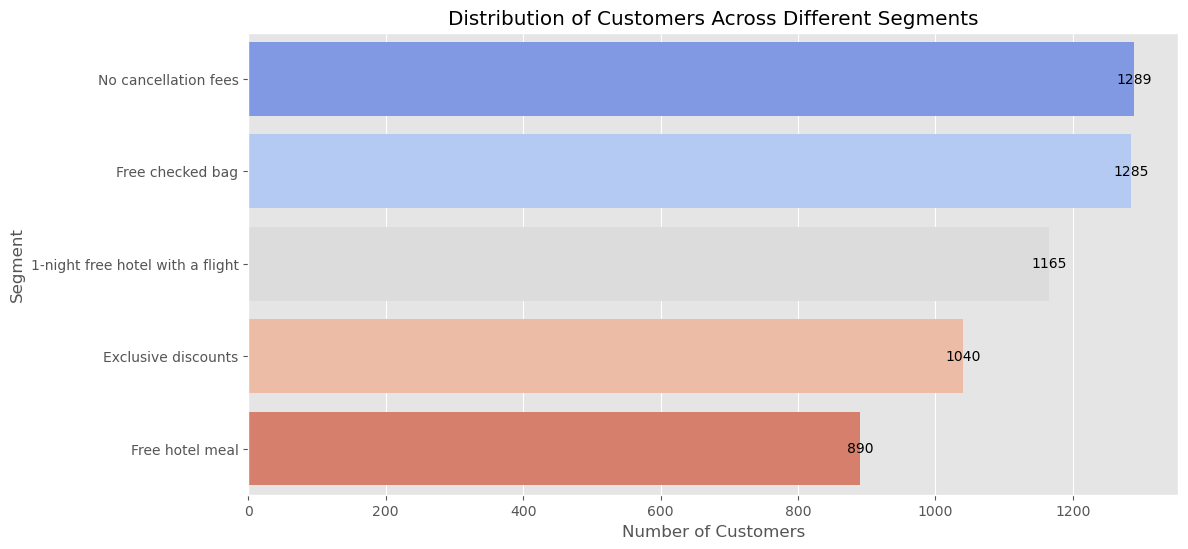

In [35]:
# Count the number of customers in each segment
segment_count = cohort_users['segment_label'].value_counts().reset_index()
segment_count.columns = ['Segment', 'Number of Customers']

# Plotting the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Number of Customers', y='Segment', data=segment_count, palette='coolwarm')
plt.title('Distribution of Customers Across Different Segments')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')

# Annotate bars with count values
for index, value in enumerate(segment_count['Number of Customers']):
    plt.text(value, index, str(value), ha='center', va='center', fontsize=10, color='black')

#plt.tight_layout()
plt.show()

The bar chart above shows the distribution of customers across different segments based on the perks they are most likely to value. The segments are:

* **No Cancellation Fees:** This segment has the highest number of customers, suggesting that flexibility in cancellation is highly valued by a significant portion of the customer base.

* **Free Checked Bag:** Closely following the first segment, this indicates that many travelers consider baggage costs when booking flights and would value a perk that offers free checked bags.

* **1-night Free Hotel with a Flight:** This is the third-largest segment, suggesting a significant number of frequent flyers who would appreciate a free hotel stay.

* **Exclusive Discounts:** This segment shows that a considerable number of customers are price-sensitive and would appreciate exclusive discounts.

* **Free Hotel Meal:** The smallest segment, but not by a large margin, indicates that a free hotel meal is also an attractive perk for a subset of the customer base.

This distribution aligns well with the Marketing team's proposed perks, suggesting that each proposed perk targets a significant customer segment.

### Average Age Across Segments:

Next, let's plot the average age of customers in each segment to see if certain perks are more appealing to different age groups.

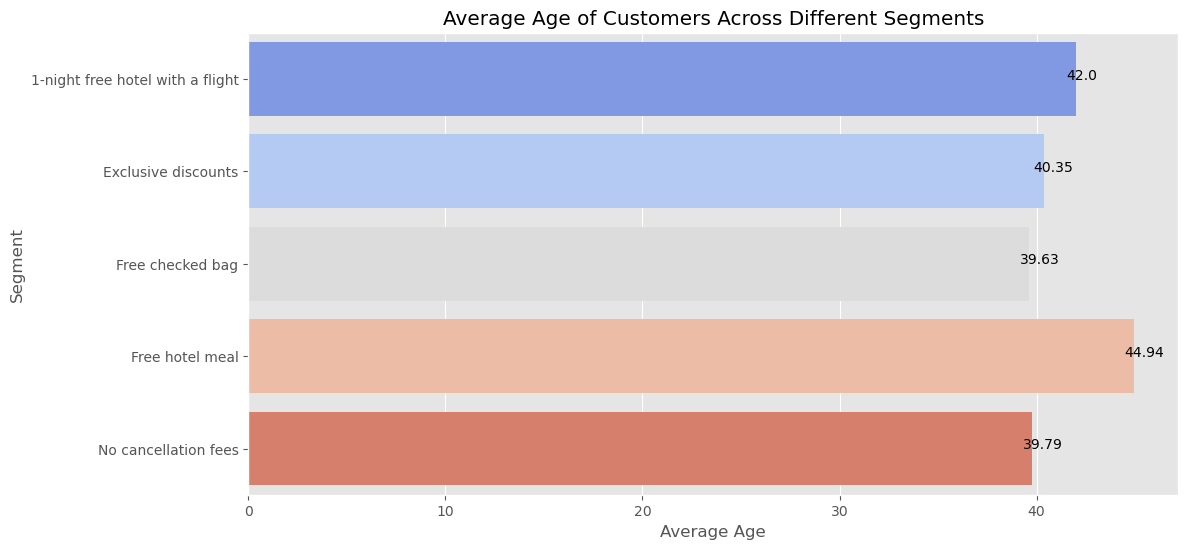

In [36]:
# Calculate the average age for each segment
avg_age_segment = cohort_users.groupby('segment_label')['age'].mean().reset_index()
avg_age_segment.columns = ['Segment', 'Average Age']

# Plotting the bar chart for average age
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Average Age', y='Segment', data=avg_age_segment, palette='coolwarm')

# Annotate the average age of each segment
for index, value in enumerate(avg_age_segment['Average Age']):
    ax.text(value - 0.5, index, str(round(value, 2)))

plt.title('Average Age of Customers Across Different Segments')
plt.xlabel('Average Age')
plt.ylabel('Segment')
plt.show()

The bar chart displays the average age of customers across different segments. As we can see the average age in all segments are very close to each other. 

* **Free Hotel Meal:** This segment has the highest average age, suggesting that older customers may find a free hotel meal more appealing. No surprise when we used **age** in the index calculation.

* **1-night Free Hotel with a Flight:** This segment has the second-highest average age.

* **No cancellation fee** and **Free Checked Bag:** These segments have the lowest average ages, suggesting that younger, might value flexibility in their travel plans and free checked bags.

This information could be valuable for targeted marketing and customization of perk offers.

### Gender Distribution Across Segments:

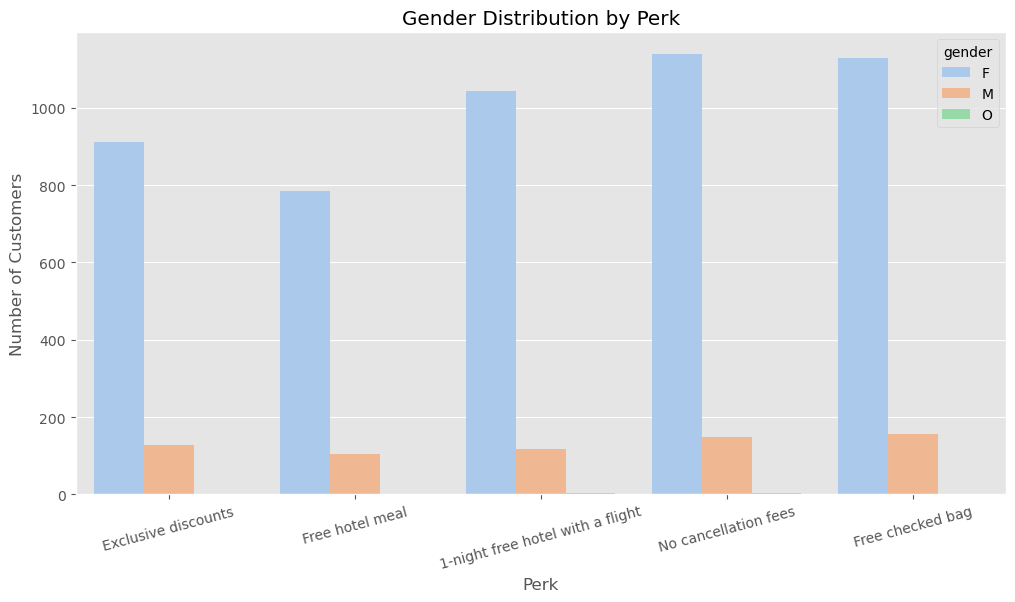

In [37]:
# Gender analysis: drawing the countplot for gender distribution across different perks using
plt.figure(figsize=(12, 6))
sns.countplot(data=cohort_users, x='segment_label', hue='gender', palette="pastel")
plt.title('Gender Distribution by Perk')
plt.xlabel('Perk')
plt.ylabel('Number of Customers')
plt.xticks(rotation=15)
plt.show()

The gender distribution across the five perks shows a consistent trend: **the number of females is higher across all perks**. This suggests that the proposed perks are more frequently aligned with female customers in our dataset.

This gender disparity may reflect the broader user base and could be significant for tailoring marketing messages or further refining the perks to appeal to a more balanced audience.

### Geographical Analysis:

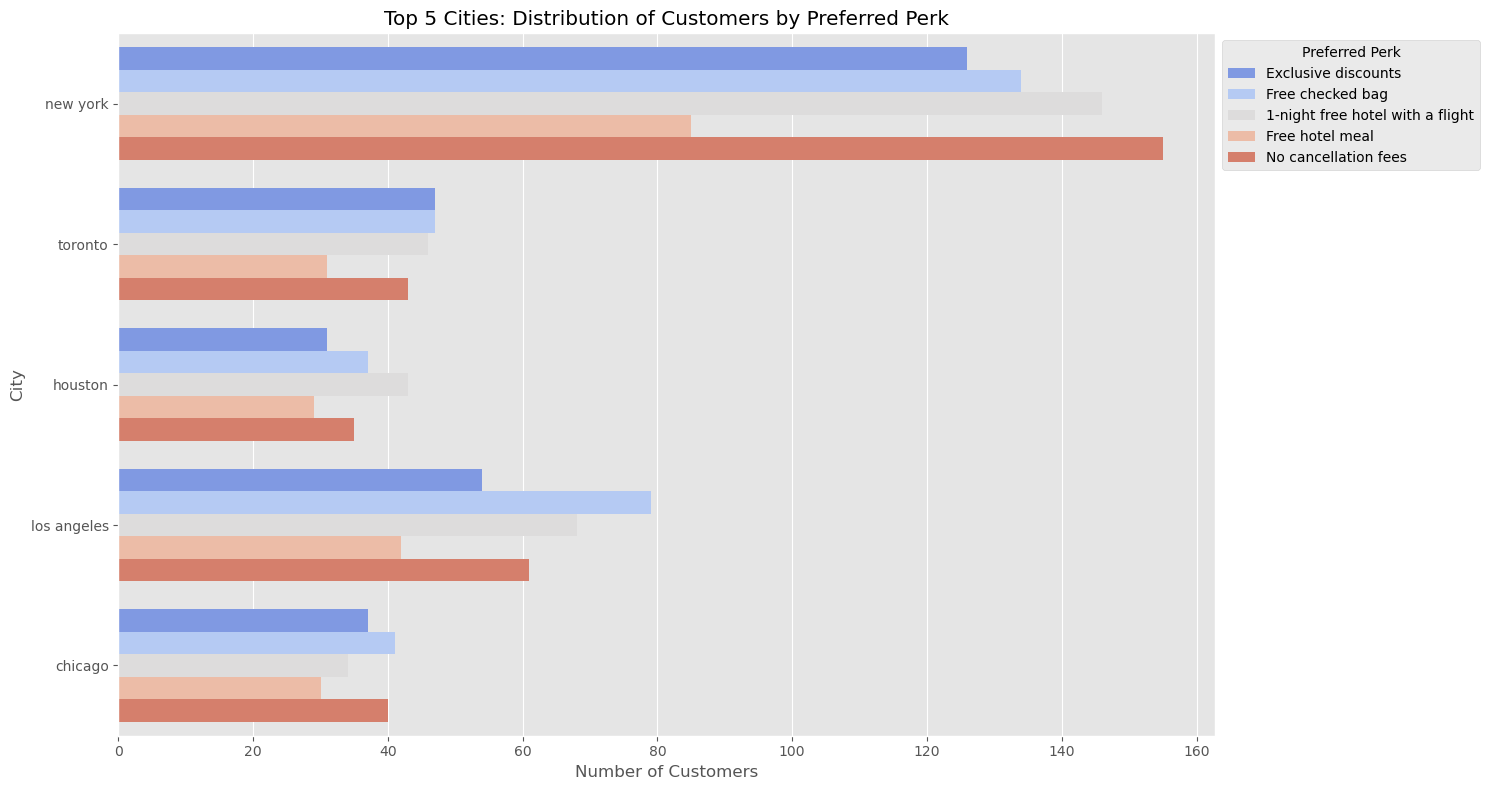

In [38]:
# Plotting the distribution of customers across top 5 cities and their most preferred perk
top_5_cities = cohort_users['home_city'].value_counts().nlargest(5).index.tolist()

# Filter the data to only include the top 5 cities
top_5_cities_data = cohort_users[cohort_users['home_city'].isin(top_5_cities)]

# Generate a horizontal bar chart for the top 5 cities
plt.figure(figsize=(15, 8))
sns.countplot(data=top_5_cities_data, y='home_city', hue='segment_label', palette="coolwarm")
plt.title('Top 5 Cities: Distribution of Customers by Preferred Perk')
plt.xlabel('Number of Customers')
plt.ylabel('City')
plt.legend(title='Preferred Perk', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

The horizontal bar chart illustrates the distribution of customers based on their preferred perks within the top 5 cities.

**New York City:** The chart shows that "No Cancellation Fees" is the most popular perk among customers, followed by "1-night Free Hotel with a Flight" and "Free checked bag."

**Toronto:**
"Exclusive discounts" and "Free Checked Bag" are the dominant perks, with "1-night Free Hotel with a Flight" also having a noticeable presence.

**Houston:**
"1-night Free Hotel with a Flight" is the most popular, followed by "Free Checked Bag" and "No cancellation fees."

**Los Angeles:**
The city shows a strong preference for "Free checked bag," followed by "1-night Free Hotel with a Flight."

**Chicago:**
"Free Checked Bag" and "No Cancellation Fees" almost have an equal number of customers, indicating a split preference for these two perks.


### Distribution of perk index values for different perks:

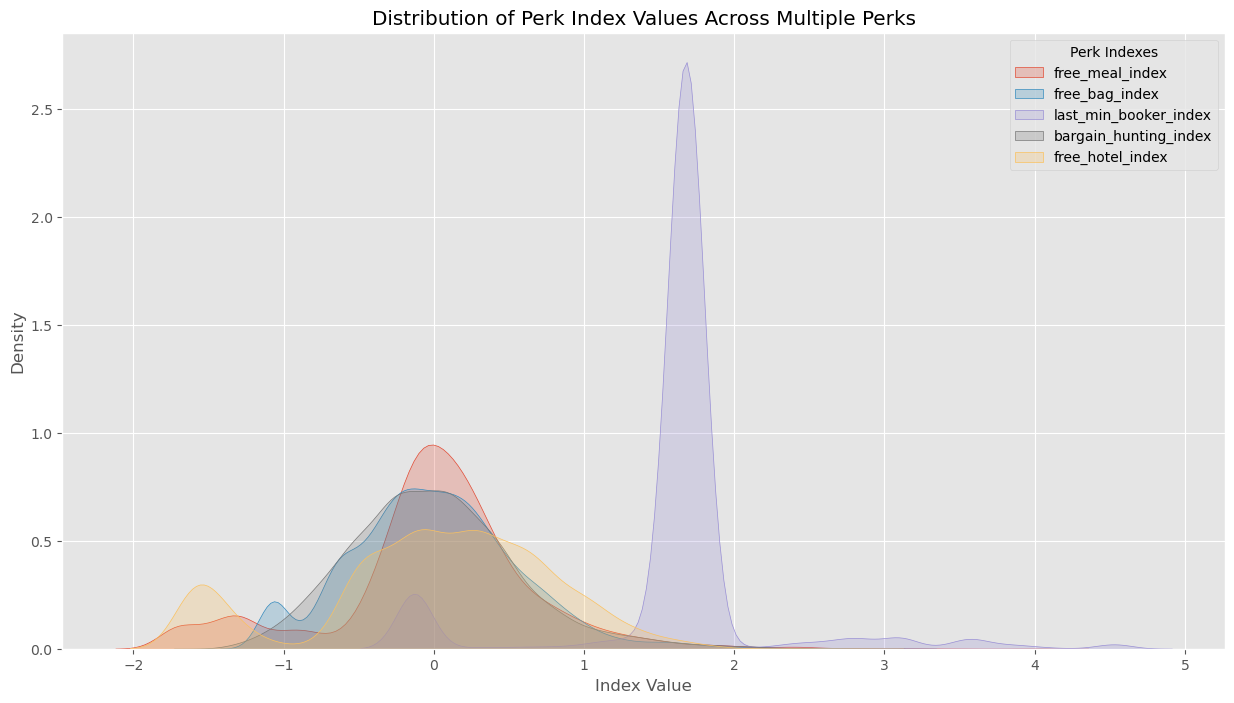

In [39]:
# Filtering only the columns that contain the indexes
index_columns = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 'bargain_hunting_index', 'free_hotel_index']

# Select only the index columns
index_data = cohort_users[index_columns]

# Plotting the distribution of index values for each user
plt.figure(figsize=(15, 8))

# Loop through the columns to plot each one
for column in index_columns:
    sns.kdeplot(index_data[column], label=column, shade=True)

plt.title('Distribution of Perk Index Values Across Multiple Perks')
plt.xlabel('Index Value')
plt.ylabel('Density')
plt.legend(title='Perk Indexes')
plt.show()

The plot visualizes the distribution of perk index values for different proposed perks. Each curve represents the density distribution of a specific index value across all users.

**Key Observations:**

**Overlap in Index Values:** Notice that the curves overlap considerably, particularly between *free_meal_index* and *free_bag_index*. This suggests that many users have similar index values for different perks, highlighting a potential overlap in perk preferences among customers.

**Wide Distribution for Some Indexes:** *last_min_booker_index* and *bargain_hunting_index* have wider distributions, indicating a greater variability in user preferences for these perks. This could mean that these perks might be more polarizing, being extremely valuable for some but not so much for others.

**Density Peaks:** Peaks in the density indicate the range of index values where most customers fall. For example, the *bargain_hunting_index* and *free_bag_index* have density peaks around 0.7, meaning that a large proportion of customers have index values in this range for these perks. This is useful information when considering how to target these perks.

This overlap in perk preferences suggests that a one-size-fits-all approach may not be the most effective for the rewards program. Some customers might find multiple perks appealing, and a more personalized approach could be more successful.

### Exploring the Overlap in Perk Preferences:

**Distribution of Index Values Across Multiple Perks**

The boxplot above provides a comprehensive view of how the index values are distributed across the five different perks. The horizontal lines represent each of the five perks, and the box represents the interquartile range of index values. In simpler terms, the wider the box, the more varied the customer preferences are for that particular perk.

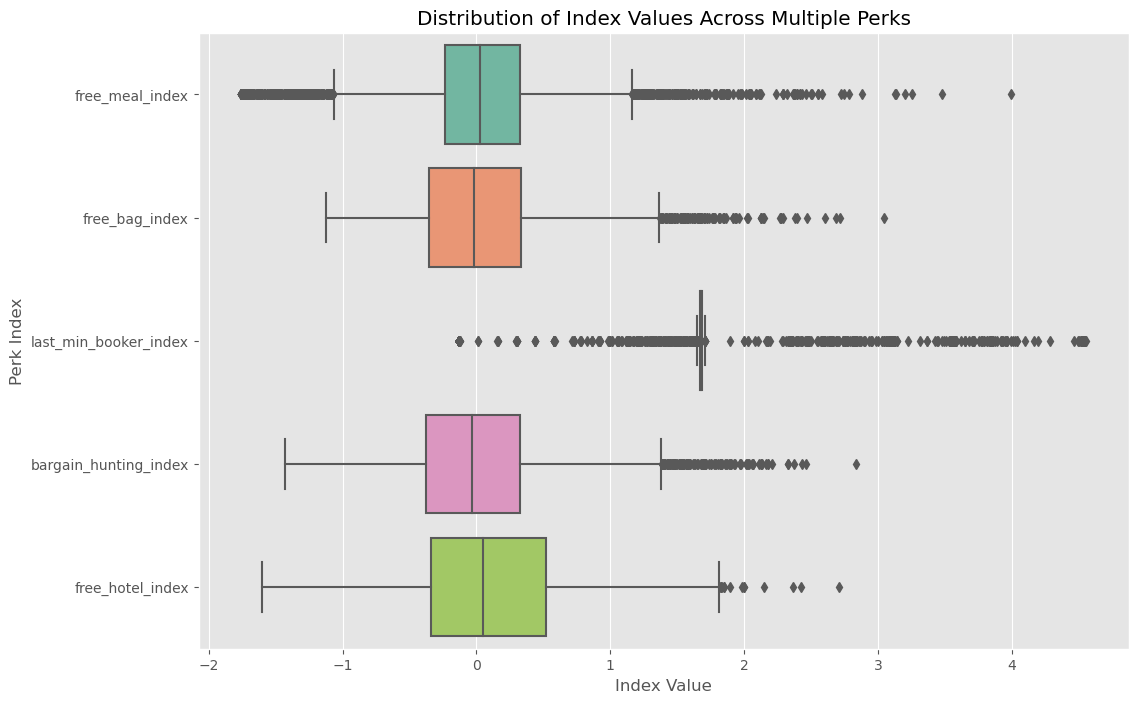

In [40]:
# Create a DataFrame containing only the perk index values for each user
perk_values_df = cohort_users[index_columns]

# Plotting the distribution of index values across multiple perks for each user
plt.figure(figsize=(12, 8))
sns.boxplot(data=perk_values_df, orient="h", palette="Set2")
plt.title('Distribution of Index Values Across Multiple Perks')
plt.xlabel('Index Value')
plt.ylabel('Perk Index')
plt.show()

**Last-Minute Booker Index:** The range of index values is quite wide, suggesting that there's a broad spectrum of customer behavior related to cancellation and last-minute bookings. This could mean that a significant number of customers are indeed concerned about cancellation fees, aligning well with Elena's proposition.

**Free Bag Index:** Similar to the Last-Minute Booker Index, the Free Bag Index also has a broad range. This indicates that free checked bags could be a significant motivator for a wide range of customers, again aligning with Elena's insight.

**Bargain Hunting Index** and **Free Hotel Index:** These indexes also exhibit a broad range, but not as wide as the first two. Nevertheless, it suggests that these perks would appeal to a somewhat diverse customer base.

**Free Meal Index:** This index has the narrowest range, suggesting that offering a free meal in hotels might be a perk that appeals to a smaller, but still significant, segment of customers.

**Key Takeaway:**

While each index is designed to capture the affinity for a specific perk, the broad range in index values across multiple perks suggests that customers may have overlapping interests. In other words, a customer with a high index value for "No Cancellation Fees" may also have a high index value for "Free Checked Bags." This overlap could be an opportunity for bundling perks or creating tiered reward programs.

By understanding this overlap, we can more effectively tailor our rewards program to meet diverse customer needs, potentially increasing customer satisfaction and loyalty.

## <font color=#DA70D6>Customer Segmentation Analysis and Next Steps</font> 

The overlap in high index values across multiple perks suggests that while we have segmented users based on their highest preference, many customers have secondary preferences that are also strong. This is a valuable insight as it provides us an opportunity to think beyond a one-perk-per-customer model.

For instance, a tiered or rotating set of perks could be considered in future phases of the rewards program. This would allow us to cater to these secondary preferences, thereby enhancing customer satisfaction and engagement with the rewards program.


#### Key Insights:

#### 1. User Preferences Align with Proposed Perks
The segmentation reveals that the Marketing team's proposed perks resonate well with specific customer behaviors. The highest affinity segments are "No Cancellation Fees" and "Free Checked Bag," with more than 1,200 customers each, showing that there's a large customer base that would appreciate these perks.

#### 2. Polarizing Perks Capture Varied Customer Interests
The index distributions for **"No Cancellation Fees"** and **"Exclusive Discounts"** are wider, indicating greater variability in customer affinity for these perks. This means that some customers highly value these options, while others do not. For example, customers who book travel far in advance may not see the value in a "No Cancellation Fees" perk. This polarizing nature isn't necessarily bad; it allows us to capture a wider range of customer interests.

#### 3. Overlap in Perk Preferences
While each user is assigned to only one segment, the index values indicate that many users have relatively high scores in multiple perks. This suggests that while we segment users based on their highest preference, they may also be interested in other perks, which provides an opportunity for cross-promotion or tiered reward systems.

#### 4. Opportunity for More Customized Offerings
The segmentation suggests that we have an opportunity to offer more nuanced perks based on the secondary preferences of our customers, allowing us to create a more compelling rewards program over time.


#### Recommendations:

#### 1. Launch Pilot Programs for Top Segments
Begin with a pilot program targeting the customers in the **"No Cancellation Fees"** and **"Free Checked Bag"** segments, as they are the largest groups.

#### 2. Consider Tiered or Rotating Perks
Given the overlap in perk preferences, consider offering a tiered or rotating set of perks that allow customers to choose from a small selection every few months. This would let us cater to secondary preferences and keep the rewards program fresh.

#### 3. Performance Monitoring:
Keep an eye on KPIs such as engagement rate, conversion rate, and customer lifetime value to measure the success of these personalized campaigns.

#### 4. Explore Partnerships for Exclusive Discounts
Since **"Exclusive Discounts"** has a broad distribution, consider partnerships with airlines or hotels to offer limited-time discounts, appealing to those with a high affinity for this perk.

#### 5. Optimize for Seasonal Variability
Consider the seasonality aspect in travel bookings to offer targeted perks. For instance, "1-night free hotel with a flight" could be more appealing during peak travel seasons.

#### 6. Periodic Re-segmentation
Customer preferences can change over time. Periodically updating these segments will keep our marketing efforts aligned with customer needs.

With these insights, we are now ready to finalize our segmented list of customers, each assigned to the perk they are most likely to appreciate. This data will serve as the foundation for the pilot phase of our rewards program. We'll now proceed to export the segmented data to a CSV file, which will include each customer's user_id and their respective segment label. This will be invaluable for downstream marketing activities.

In [41]:
final_segmentation_df = cohort_users[['user_id','segment_label']]

# Save the DataFrame to a CSV file
final_segmentation_df.to_csv('TravelTide_Customer_Segmentation_Fuzzy.csv', index=False)

# Display the first few rows of the final DataFrame
final_segmentation_df.head()

,user_id,segment_label
0,23557,Exclusive discounts
1,94883,Free hotel meal
2,101961,1-night free hotel with a flight
3,149058,1-night free hotel with a flight
4,152583,No cancellation fees
